# Data Wrangling, Cleaning, and Visualization

## Clean and Collect

The [Real Clear Politics](http://www.realclearpolitics.com) website archives many political polls. In addition, they combine related polls to form an "RCP average" estimate of public opinion over time. For example, the chart on [this page](http://www.realclearpolitics.com/epolls/2012/president/us/general_election_romney_vs_obama-1171.html) shows historical polling data for the Obama-Romney presidential race. The chart is an average of the polling data table below the chart.

The data used to generate plots like this are stored as XML pages, with URLs like:

http://charts.realclearpolitics.com/charts/[id].xml

Here, [id] is a unique integer, found at the end of the URL of the page that displays the graph. The id for the Obama-Romney race is 1171:

http://charts.realclearpolitics.com/charts/1171.xml

We'd use the data from the xml page with **id - 1044** in this part.

In [25]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from fnmatch import fnmatch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern3 import web
import matplotlib
import bs4
from bs4 import BeautifulSoup

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.prop_cycle'] = matplotlib.cycler(color=dark2_colors)
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

In [26]:
def get_poll_xml(poll_id):
    url = "http://charts.realclearpolitics.com/charts/" + str(poll_id) + ".xml"
    xml = requests.get(url).text
    return xml

In [27]:
# "r"egular "e"xpressions is kind of a mini-language to
# do pattern matching on text
import re

def _strip(s):
    """This function removes non-letter characters from a word
    
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)

def plot_colors(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    dom = web.Element(xml)
    result = {}
    for graph in dom.by_tag('graph'):
        title = _strip(graph.attributes['title'])
        result[title] = graph.attributes['color']
    return result

In [143]:
def rcp_poll_data(xml):
    '''
    
    Function
    ---------
    rcp_poll_data

    Extract poll information from an XML string, and convert to a DataFrame

    Parameters
    ----------
    xml : str
        A string, containing the XML data from a page like 
        get_poll_xml(1044)
        
    Returns
    -------
    A pandas DataFrame with the following columns:
        date: The date for each entry
        title_n: The data value for the gid=n graph (take the column name from the `title` tag)
        
    This DataFrame should be sorted by date
        
    Example
    -------
    Consider the following simple xml page:
    
    <chart>
    <series>
    <value xid="0">1/27/2009</value>
    <value xid="1">1/28/2009</value>
    </series>
    <graphs>
    <graph gid="1" color="#000000" balloon_color="#000000" title="Approve">
    <value xid="0">63.3</value>
    <value xid="1">63.3</value>
    </graph>
    <graph gid="2" color="#FF0000" balloon_color="#FF0000" title="Disapprove">
    <value xid="0">20.0</value>
    <value xid="1">20.0</value>
    </graph>
    </graphs>
    </chart>
    
    Given this string, rcp_poll_data should return
    result = pd.DataFrame({'date': pd.to_datetime(['1/27/2009', '1/28/2009']), 
                           'Approve': [63.3, 63.3], 'Disapprove': [20.0, 20.0]})
    '''
    dom = web.Element(xml)
    result = {}
    
    dates = dom.by_tag('series')[0]    
    dates = {n.attributes['xid']: str(n.content) for n in dates.by_tag('value')}
    
    keys = dates.keys()
    
    result['date'] = pd.to_datetime([dates[k] for k in keys])
    
    for graph in dom.by_tag('graph'):
        name = graph.attributes['title']
        data = {n.attributes['xid']: float(n.content) 
                if n.content else np.nan for n in graph.by_tag('value')}
        result[name] = [data[k] for k in keys]
        
    result = pd.DataFrame(result)    
    result = result.sort_values(by = 'date')
    return result

In [29]:
def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    xml = get_poll_xml(poll_id)
    data = rcp_poll_data(xml)
    colors = plot_colors(xml)

    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})

    #normalize poll numbers so they add to 100%    
    norm = data[colors.keys()].sum(axis=1) / 100    
    for c in colors.keys():
        data[c] /= norm
    
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label=label)        
        
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")

Text(0.5, 1.0, 'Obama Job Approval')

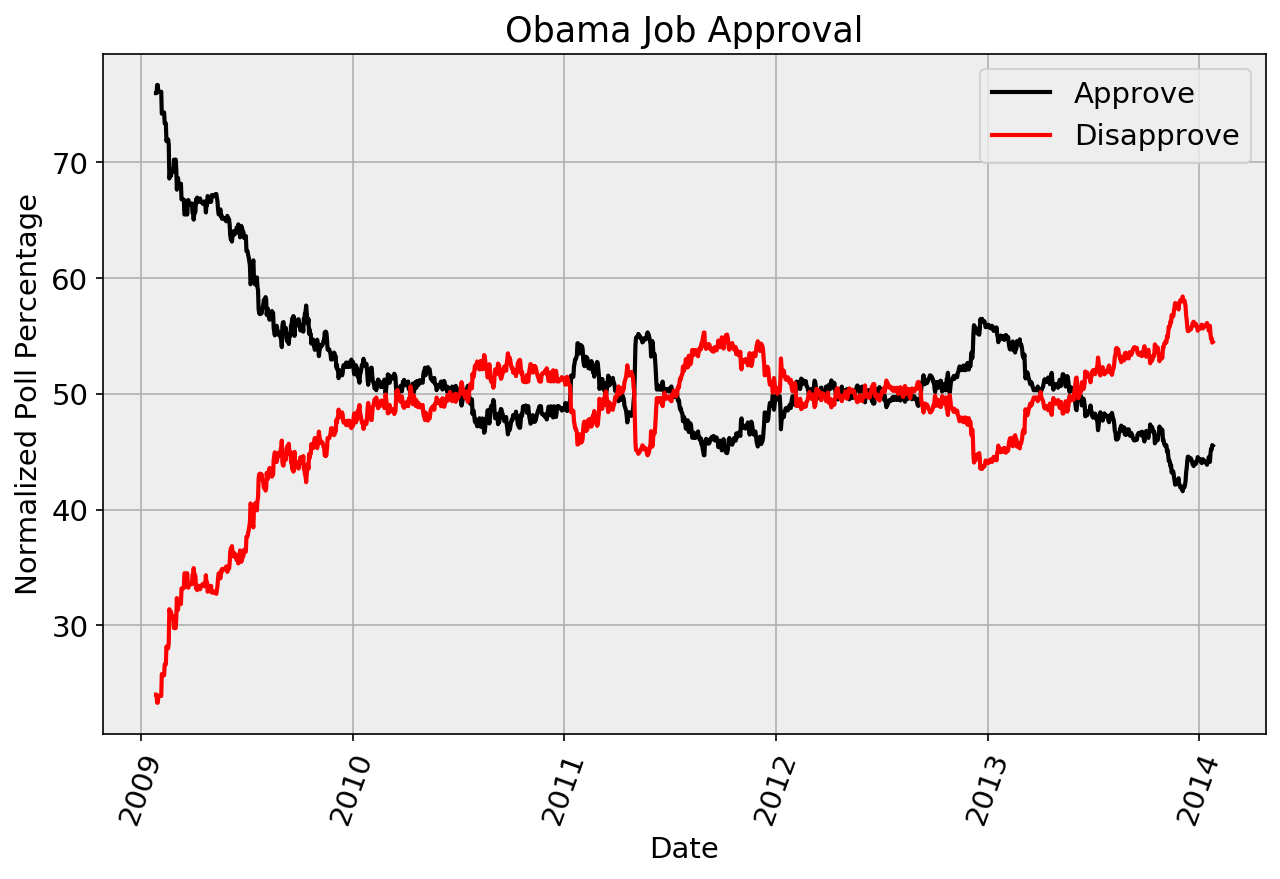

In [30]:
poll_plot(1044)
plt.title("Obama Job Approval")

## Aggregate and Visualize

The above information is inconclusive as we haven't taken into account the uncertainities. For example, If a candidate leads by 10% in the RCP average, is she a shoo-in to win? Or is this number too close to call? Does a 10% poll lead mean more 1 day before a race than it does 1 week before? Without error estimates, these questions are impossible to answer.

To get a sense of how accurate the RCP polls are, we will gather data from many previous Governor races, where the outcome is known.

This url has links to many governer races. 

http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html

Each link to a governor race has the following URL pattern:

http://www.realclearpolitics.com/epolls/[YEAR]/governor/[STATE]/[TITLE]-[ID].html

In [165]:
def is_gov_race(l):
    """return True if a URL refers to a Governor race"""    
    pattern = '*/epolls/????/governor/??/*-*.html'
    return fnmatch(l, pattern)

def find_governor_races(html):
    """
    Function
    --------
    find_governor_races

    Find and return links to RCP races on a page like
    http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html
    
    Parameters
    ----------
    html : str
        The HTML content of a page to scan
        
    Returns
    -------
    A list of urls for Governer race pages
    
    Example
    -------
    For a page like
    
    <html>
    <body>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html"></a>
    <a href="http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html"></a>
    </body>
    </html>
    
    find_governor_races would return
    ['http://www.realclearpolitics.com/epolls/2010/governor/ma/massachusetts_governor_baker_vs_patrick_vs_cahill-1154.html',
     'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html']
    """    
    dom = web.Element(html)
    links = [a.attributes.get('href', '') for a in dom.by_tag('a')] 
    links = [l for l in links if is_gov_race(l)]
    tlinks = [base + l if l[0] != 'h' else l for l in links]
    tlinks = list(set(tlinks))
    return tlinks

# html = requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text
# races = find_governor_races(html)
# [race for race in races]
# base = "http://www.realclearpolitics.com"
# races = [base + race for race in races if race[0] != "h"]

In [166]:
def race_result(url):
    """
    Function
    --------
    race_result

    Return the actual voting results on a race page
    
    Parameters
    ----------
    url : string
        The website to search through
        
    Returns
    -------
    A dictionary whose keys are candidate names,
    and whose values is the percentage of votes they received.
    
    If necessary, normalize these numbers so that they add up to 100%.
    
    Example
    --------
    >>> url = 'http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html'
    >>> race_result(url)
    {'Brown': 56.0126582278481, 'Whitman': 43.9873417721519}
    """
    dom = web.Element(requests.get(url).text)
    tables = dom.by_tag('div#polling-data-rcp')
    result = dom.by_tag('tr.final')[0]
    headers = [str(name.content.split('(')[0].strip()) for name in tables[0].by_tag('th')[3:-1]]
    votes = [float(vote.content) for vote in result.by_tag('td')[3:-1]]
    tot = sum(votes) / 100
    return {l:r / tot for l, r in zip(headers, votes)}


In [167]:
def id_from_url(url):
    """Given a URL, look up the RCP identifier number"""
    return url.split('-')[-1].split('.html')[0]


def plot_race(url):
    """Make a plot summarizing a senate race
    
    Overplots the actual race results as dashed horizontal lines
    """
    #hey, thanks again for these functions!
    id = id_from_url(url)
    xml = get_poll_xml(id)    
    colors = plot_colors(xml)

    if len(colors) == 0:
        return
    
    #really, you shouldn't have
    result = race_result(url)
    
    poll_plot(id)
    plt.xlabel("Date")
    plt.ylabel("Polling Percentage")
    for r in result:
        plt.axhline(result[r], color=colors[_strip(r)], alpha=0.6, ls='--')

Now that this is done, we can easily visualize many historical Governer races. The solid line plots the poll history, the dotted line reports the actual result.

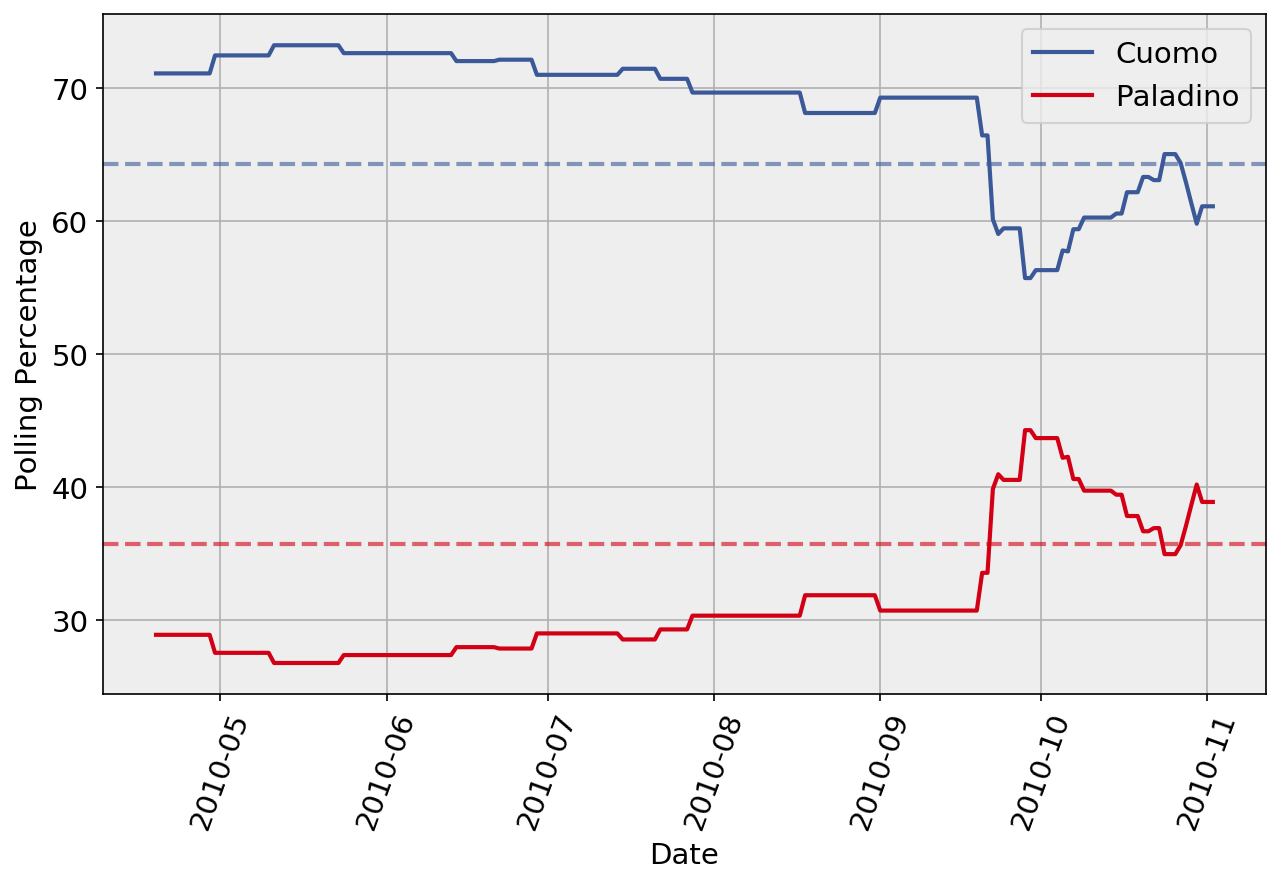

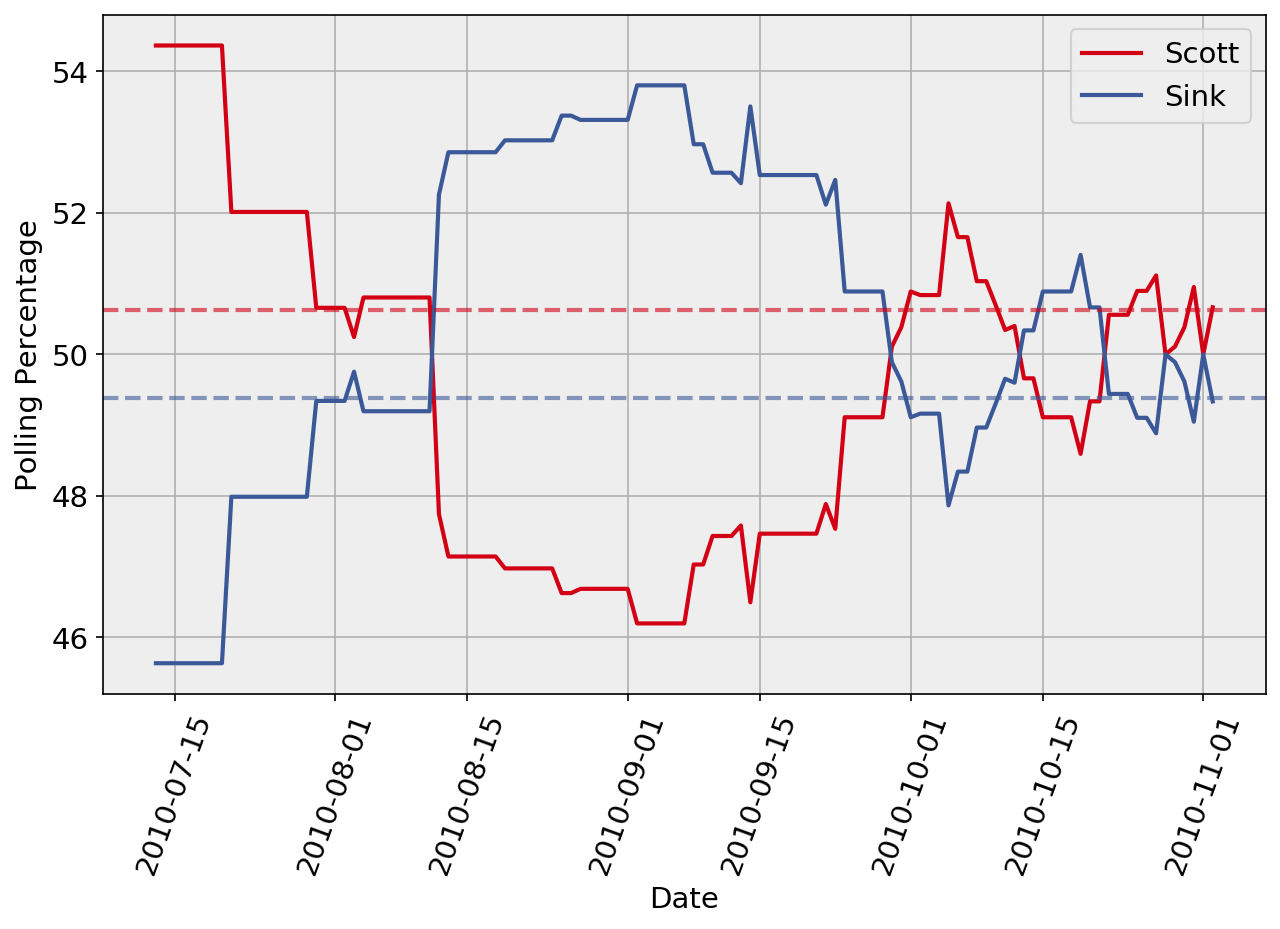

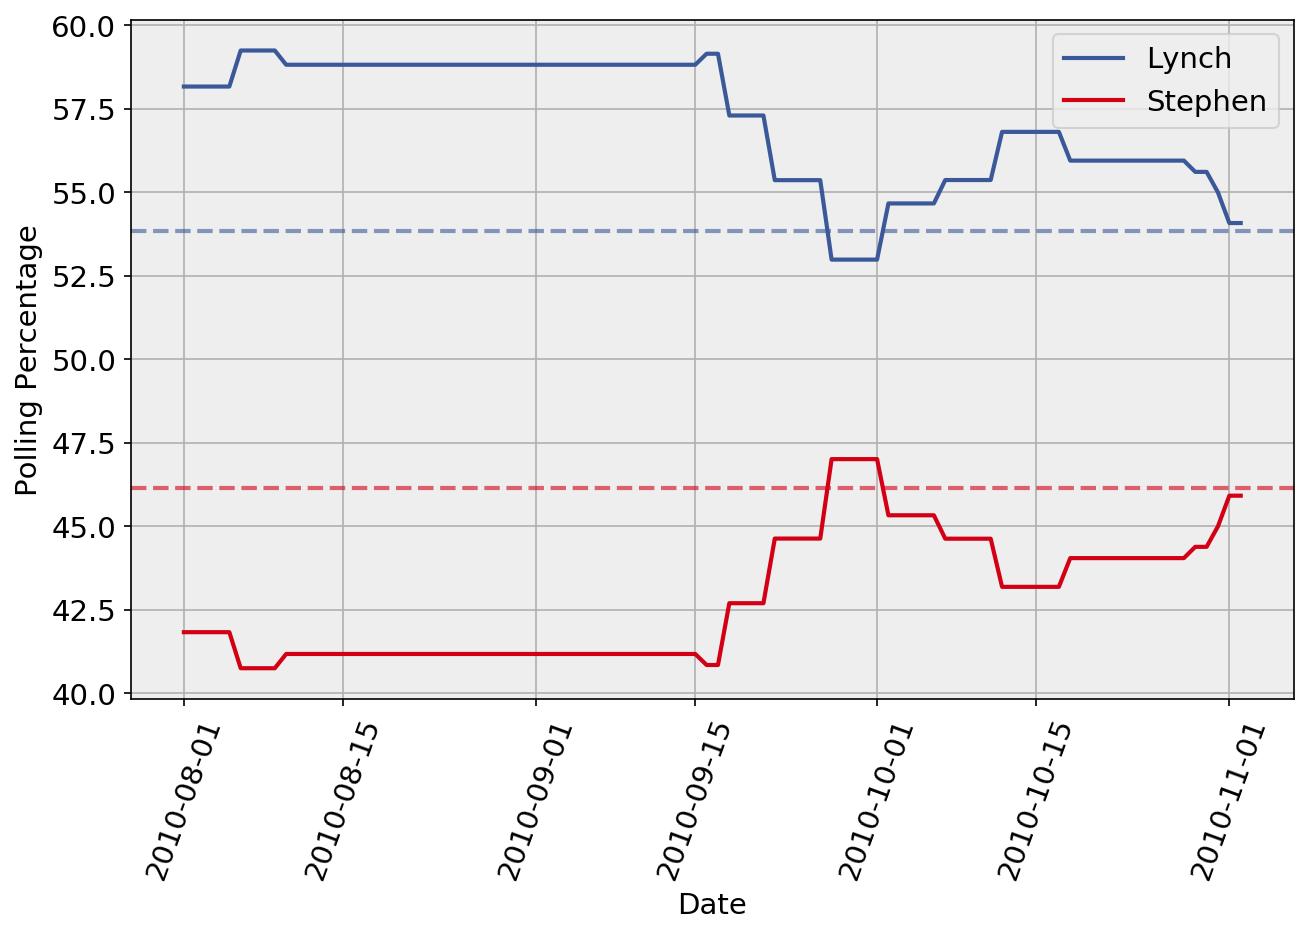

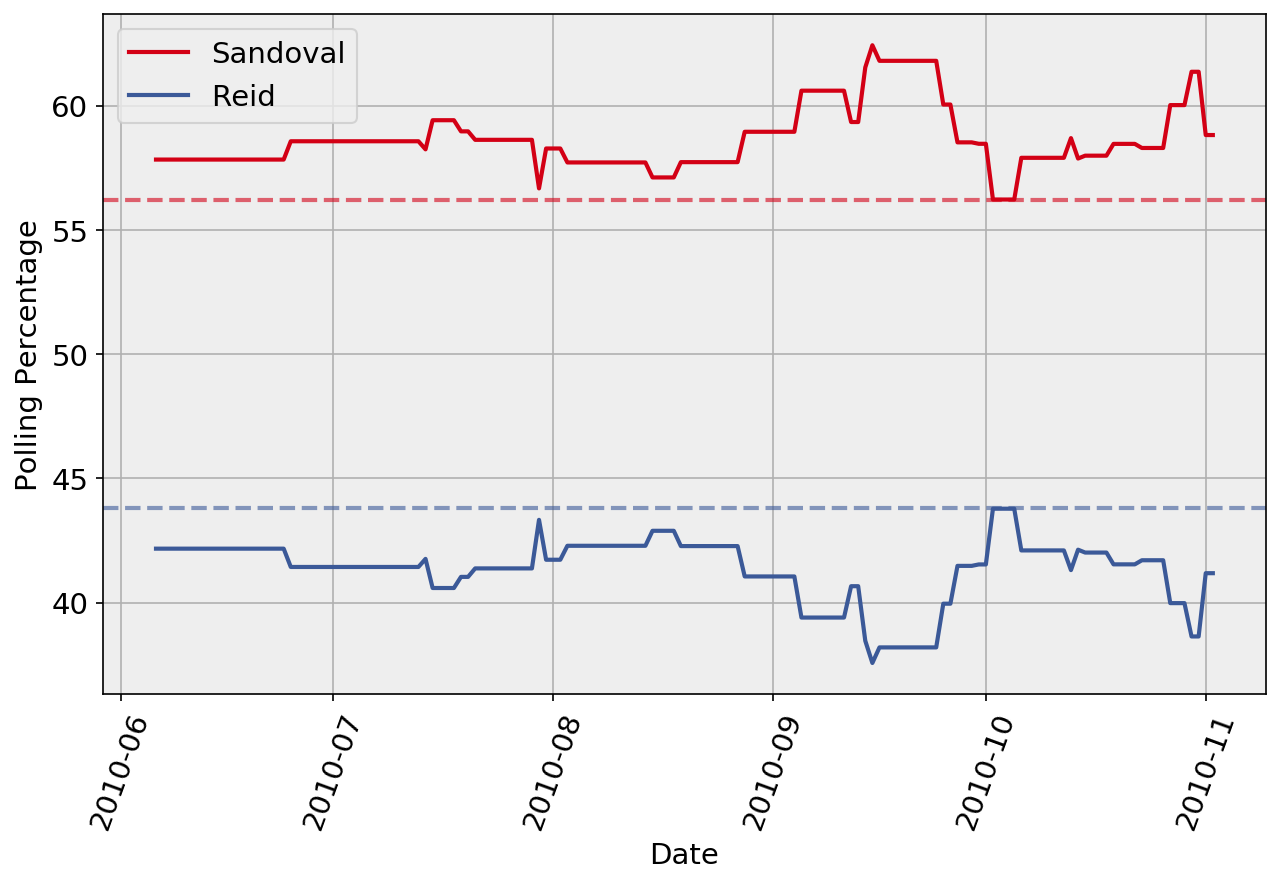

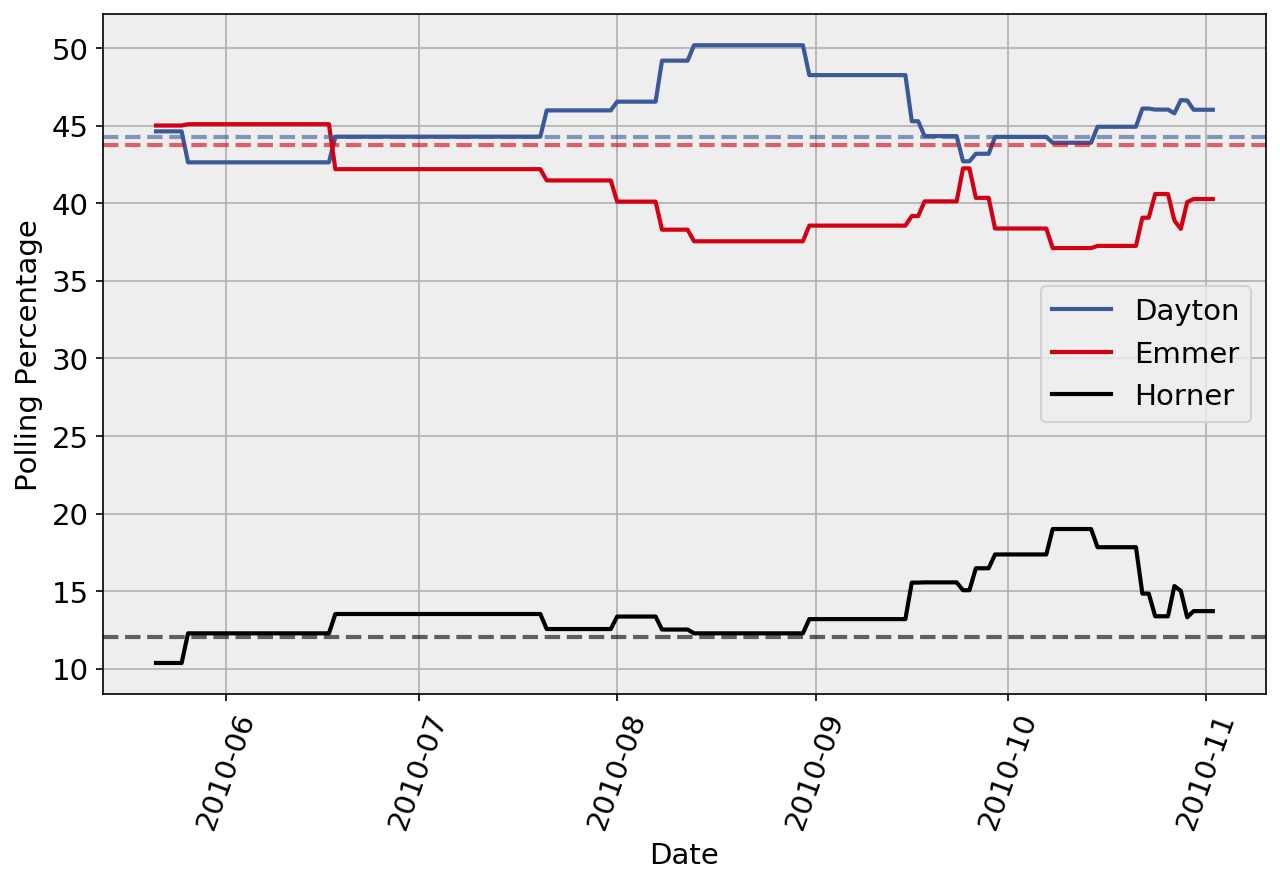

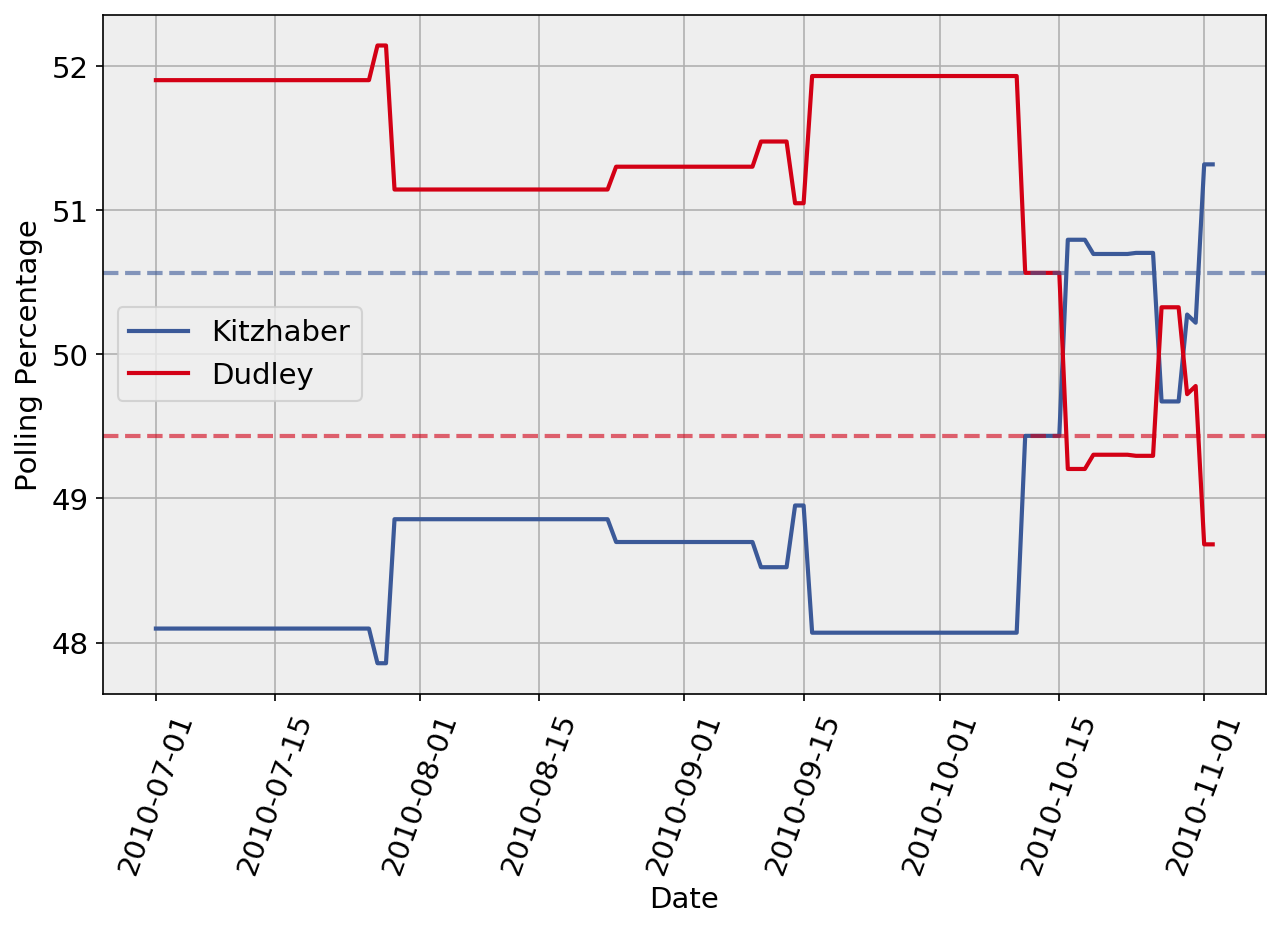

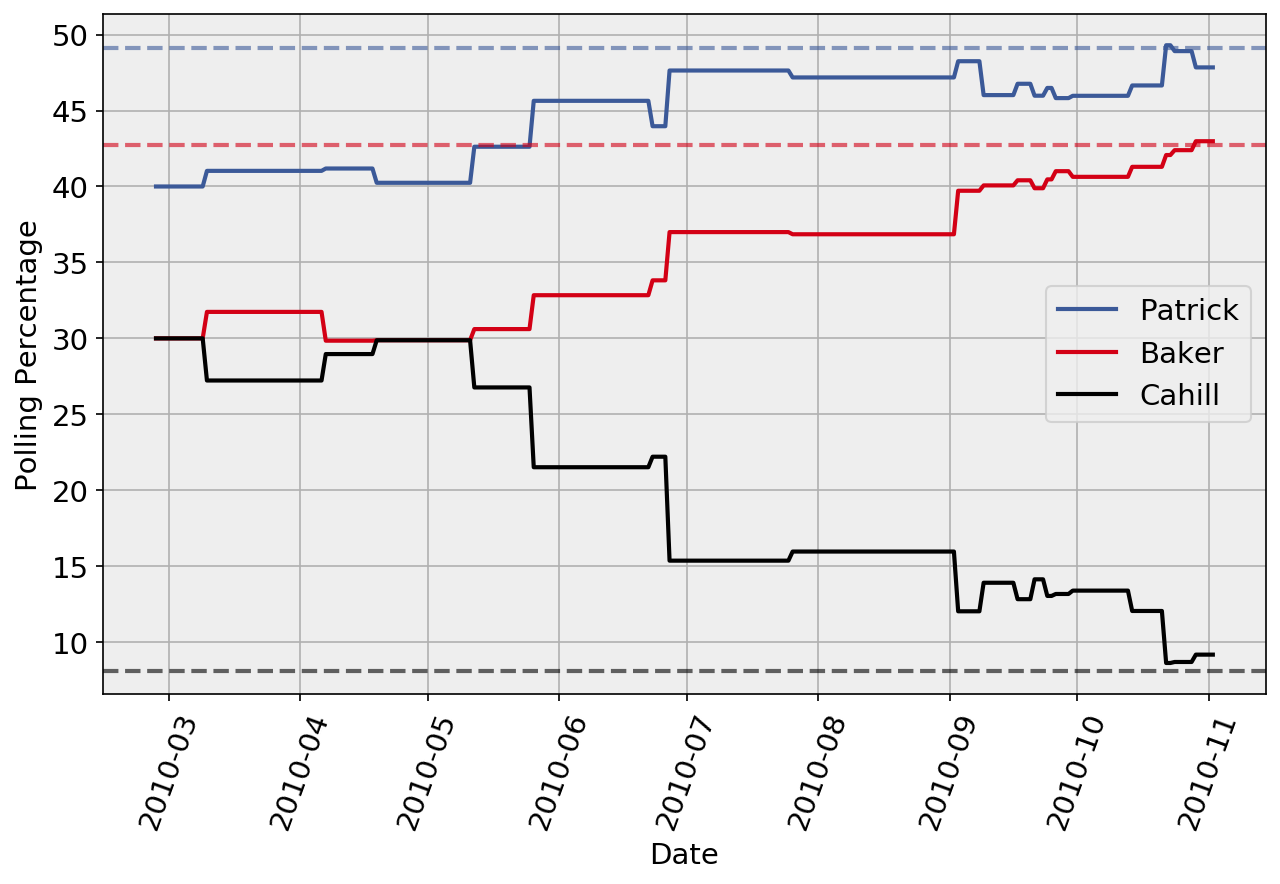

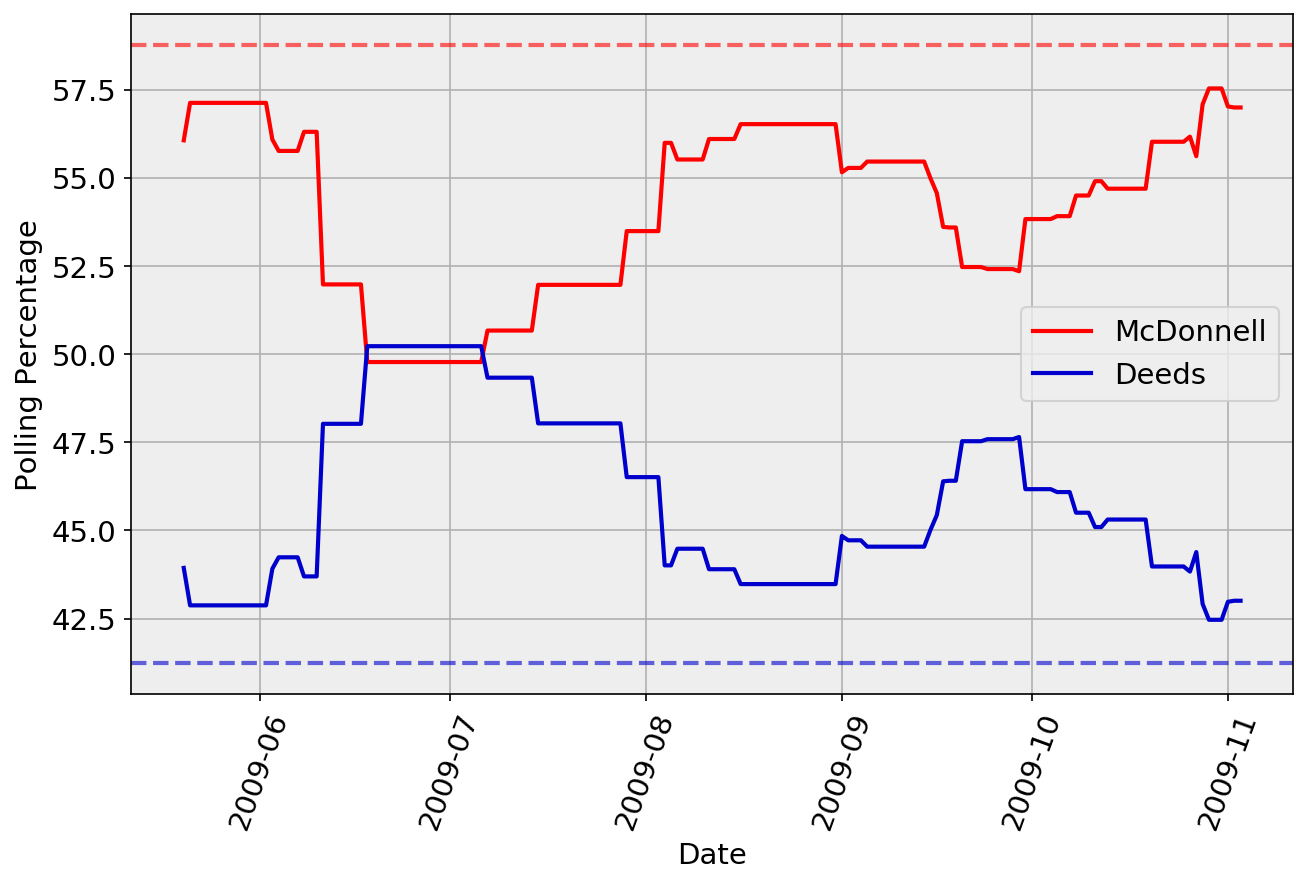

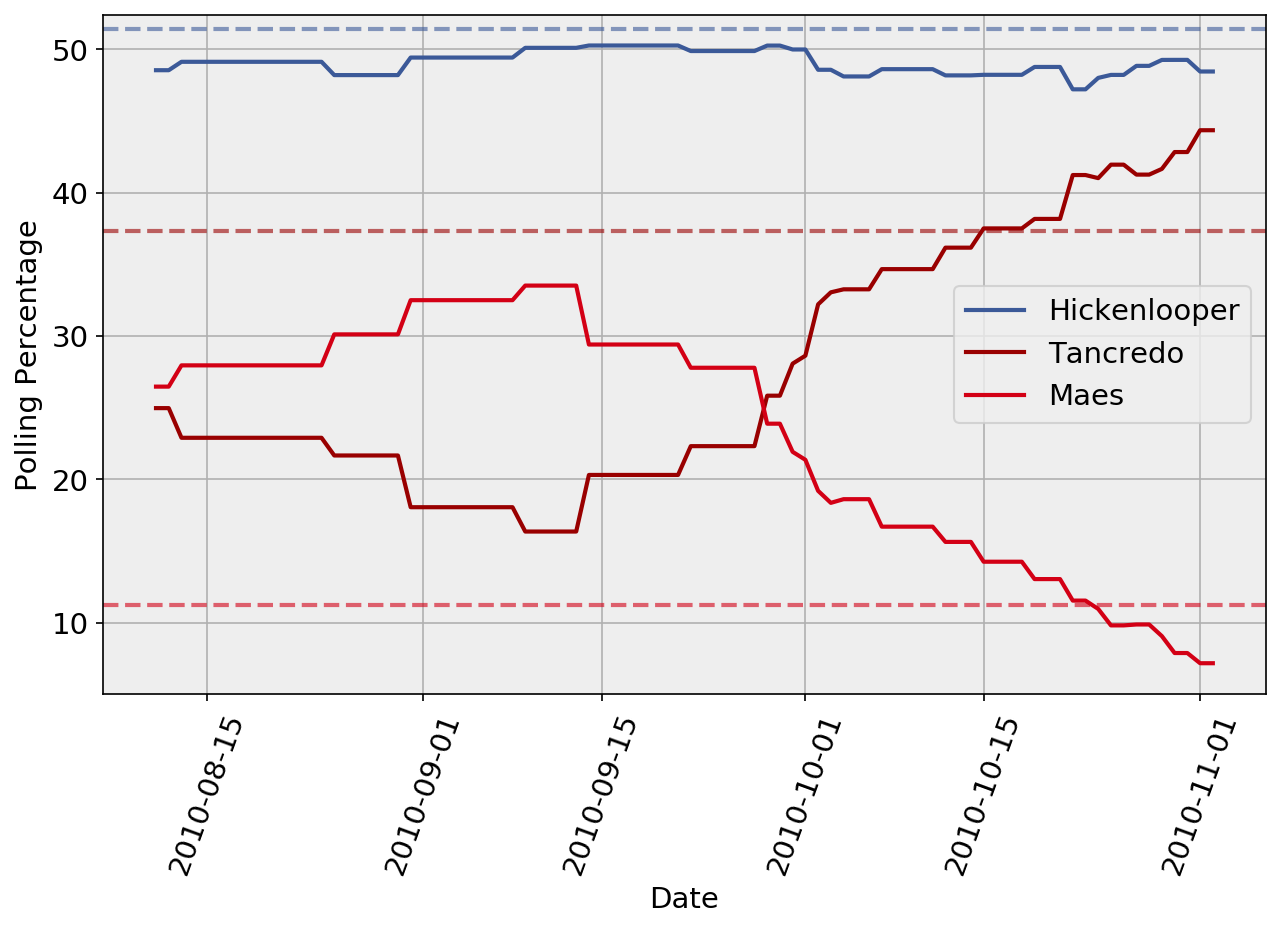

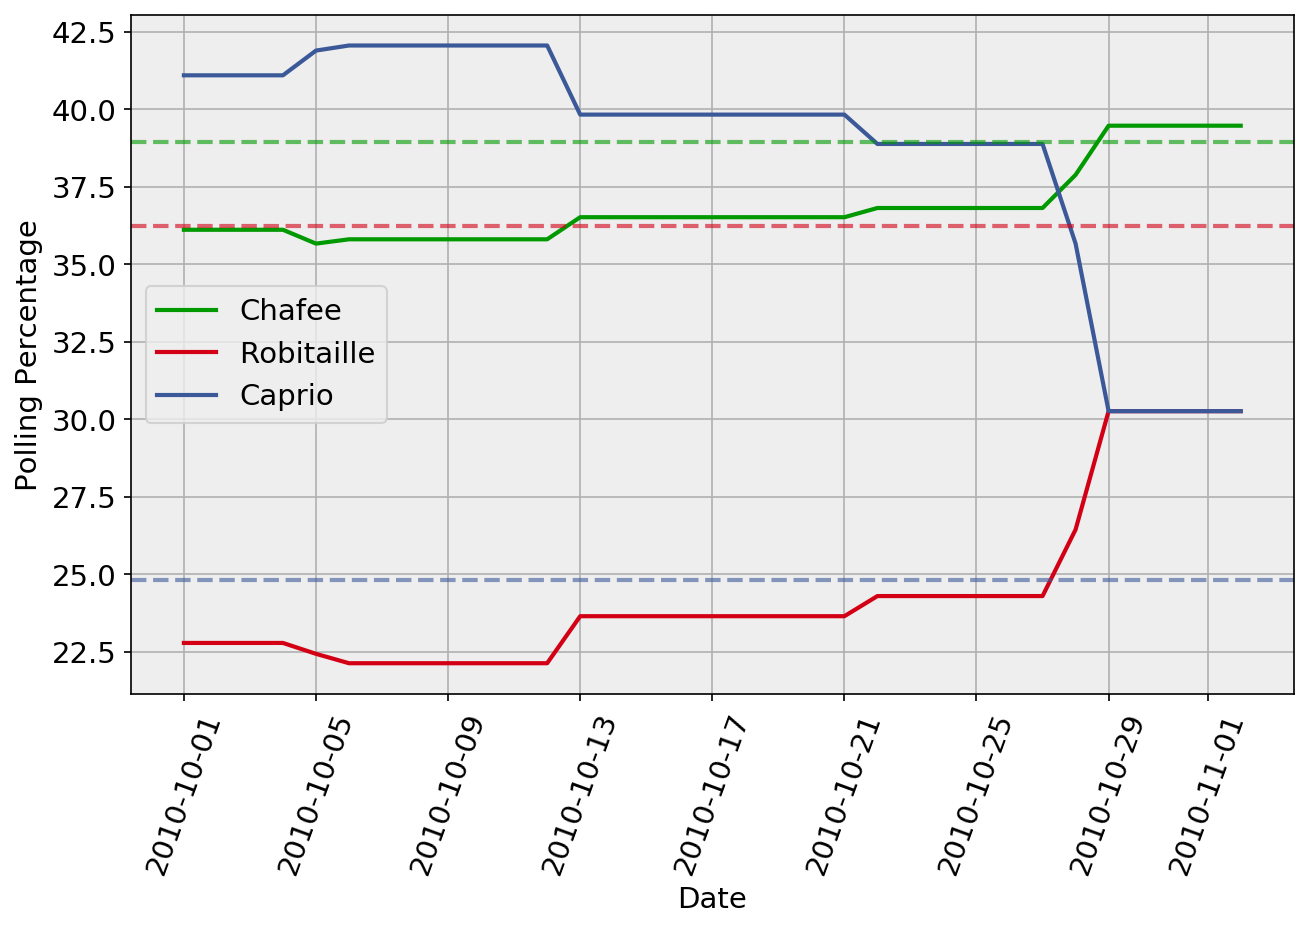

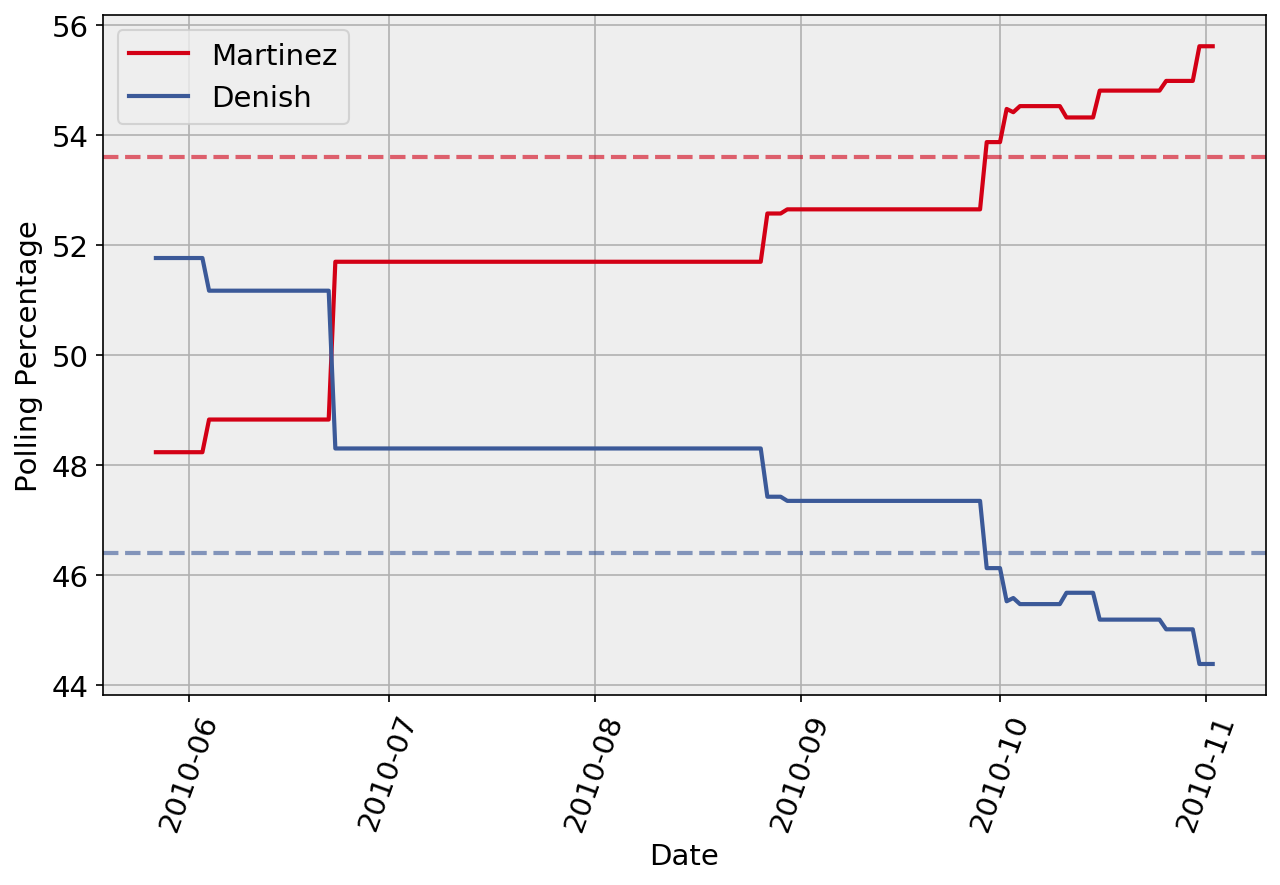

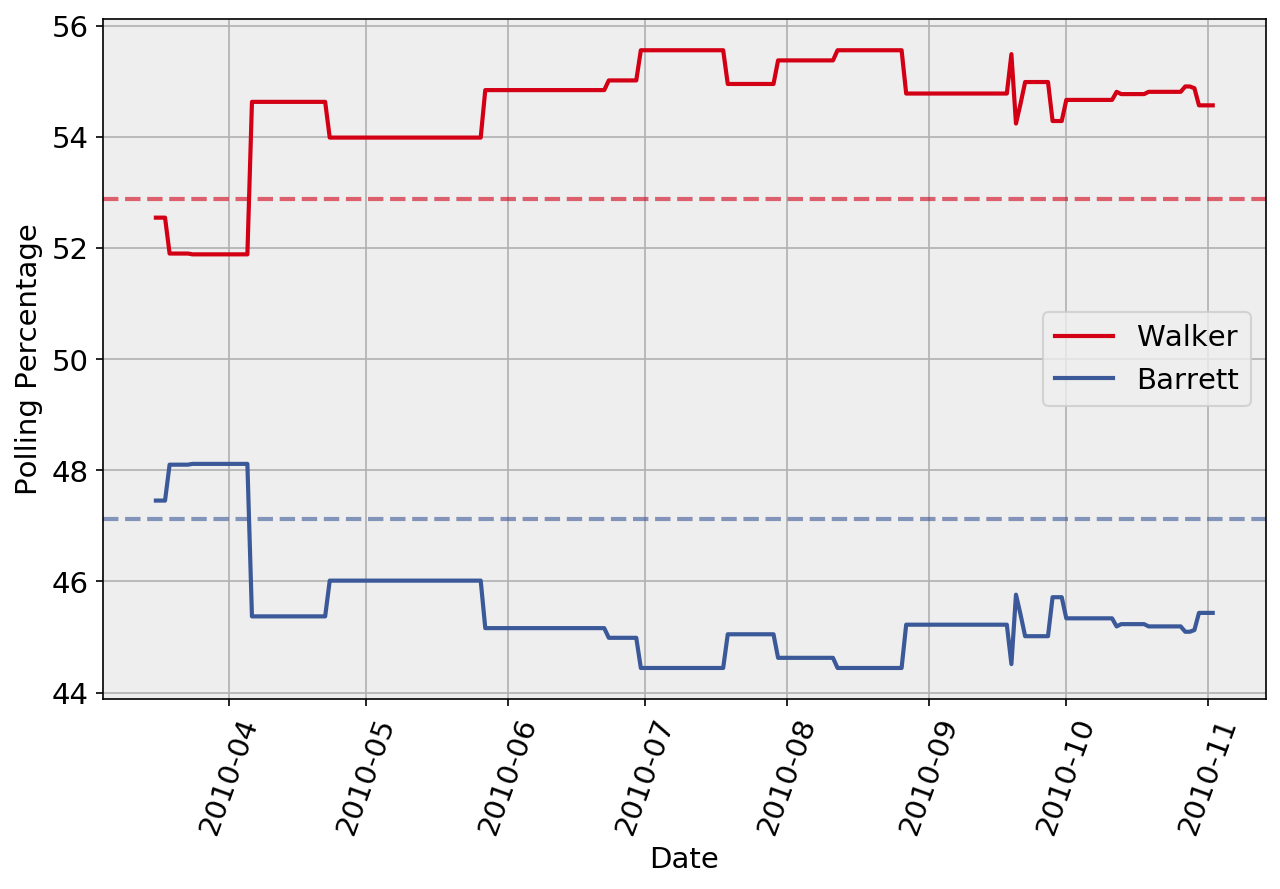

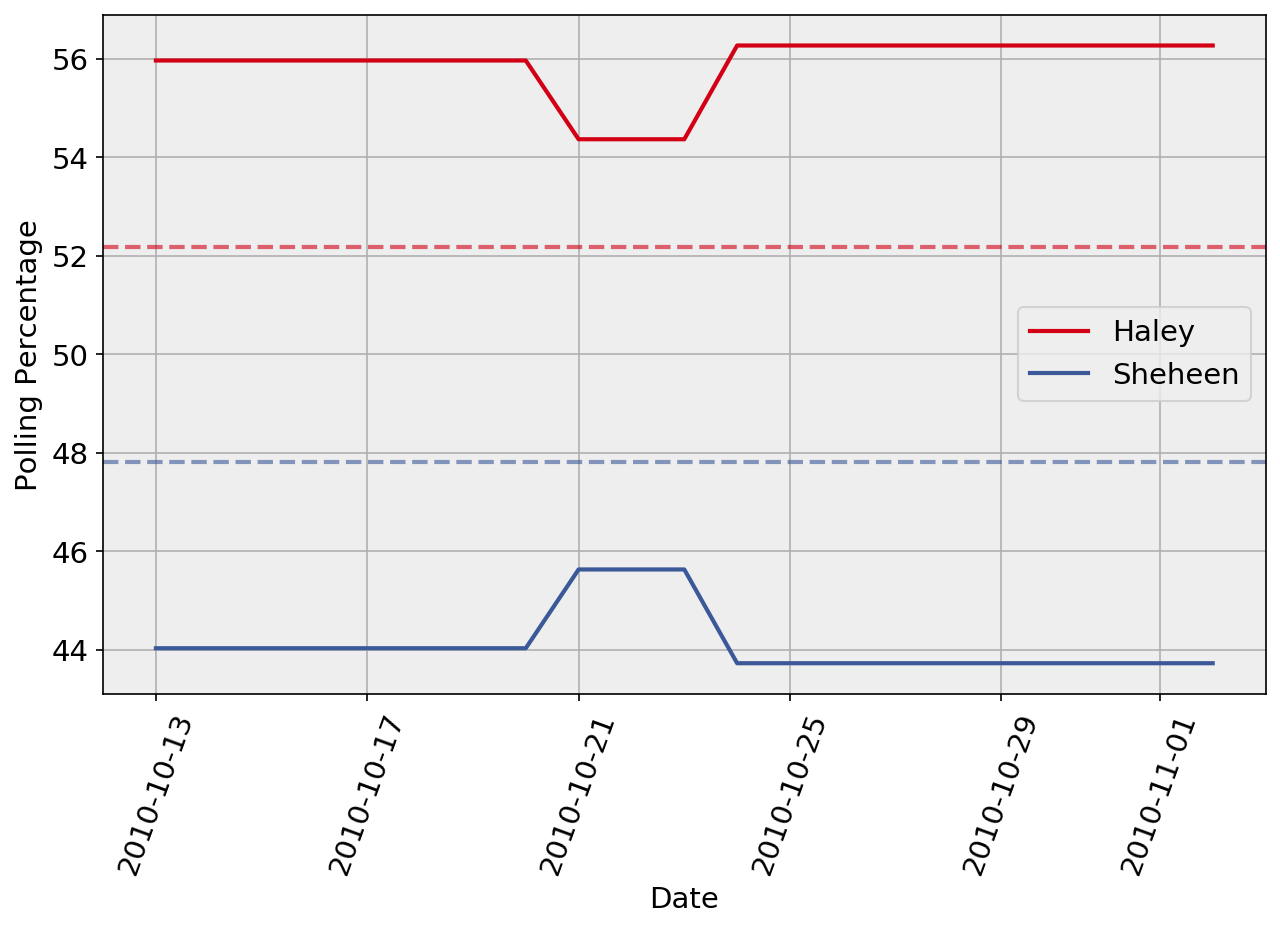

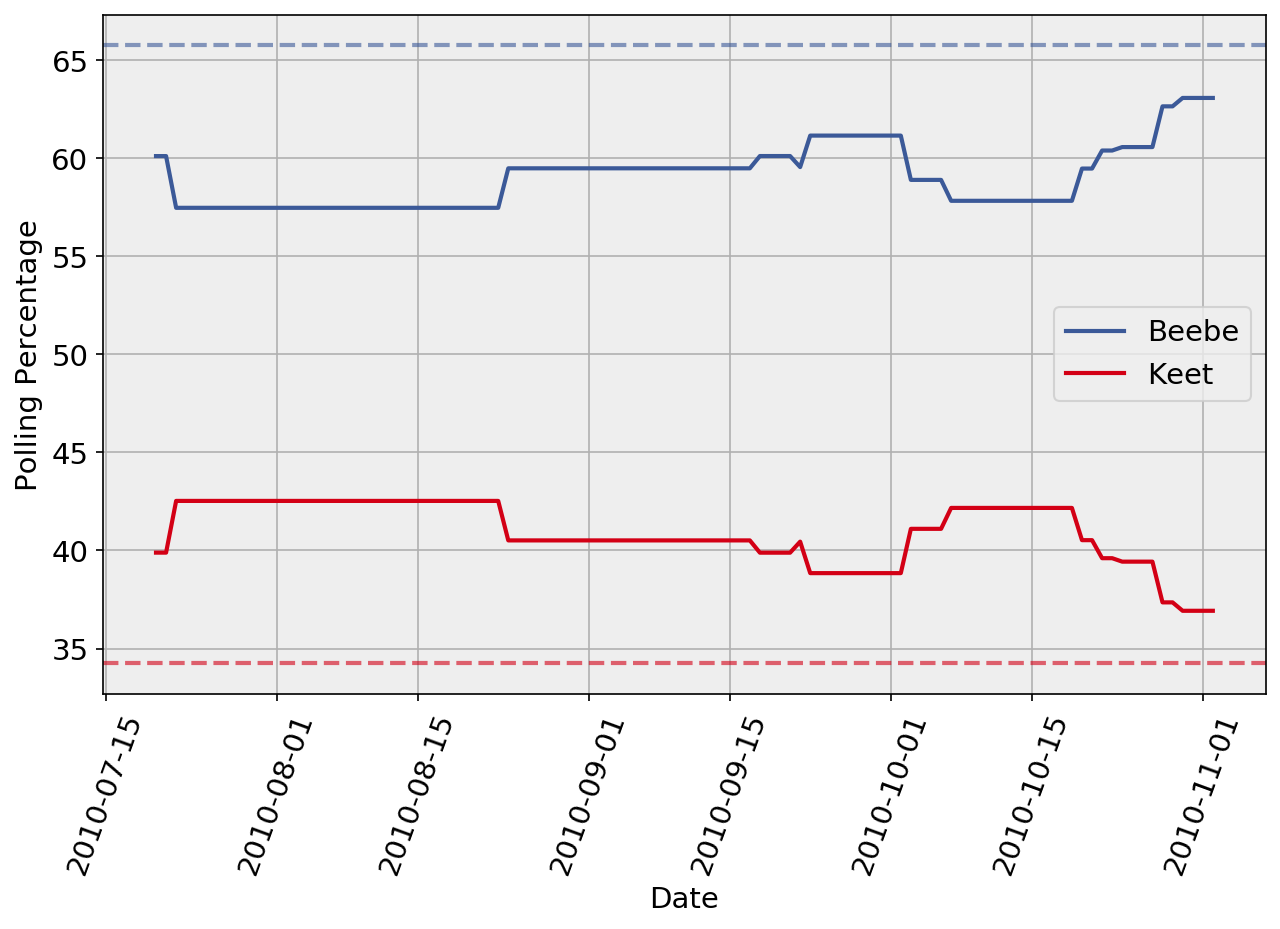

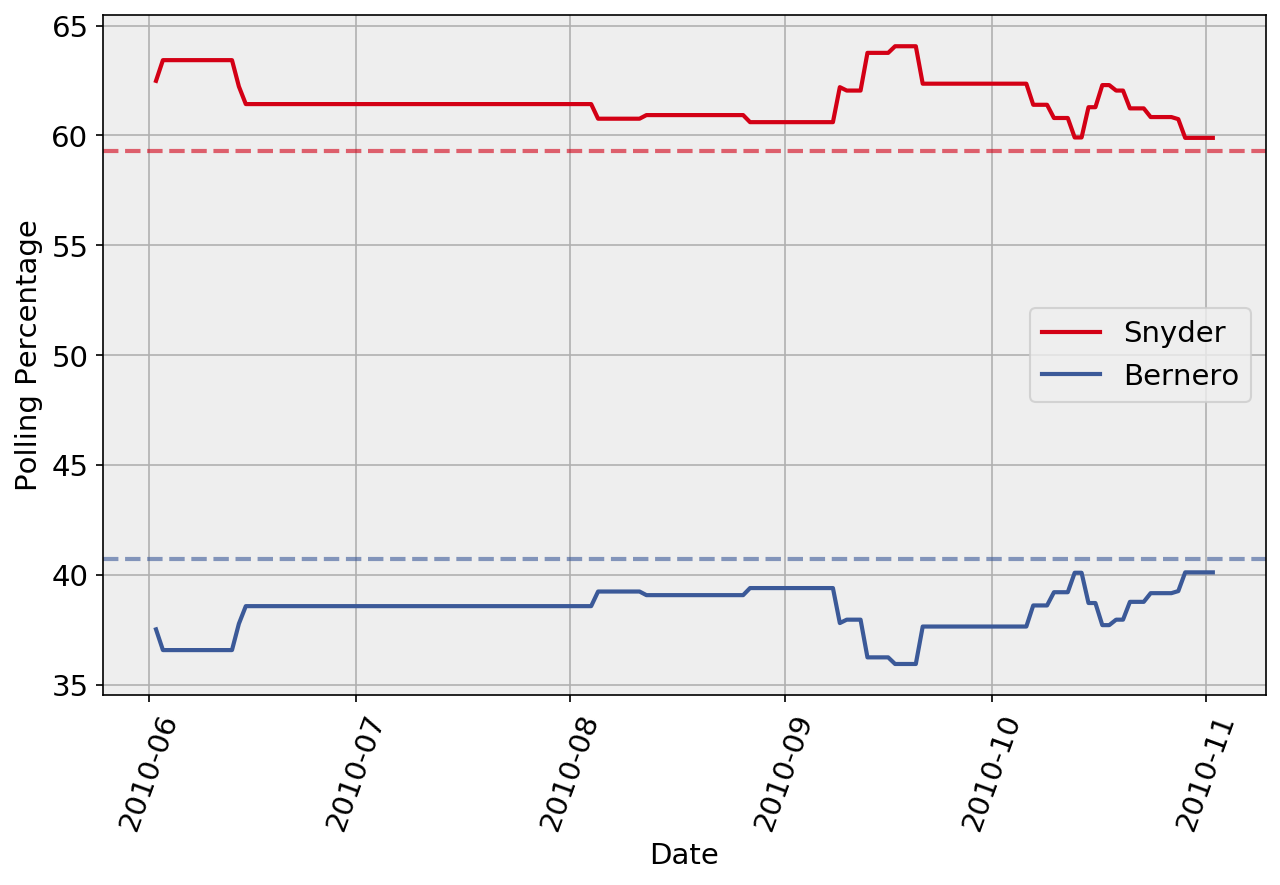

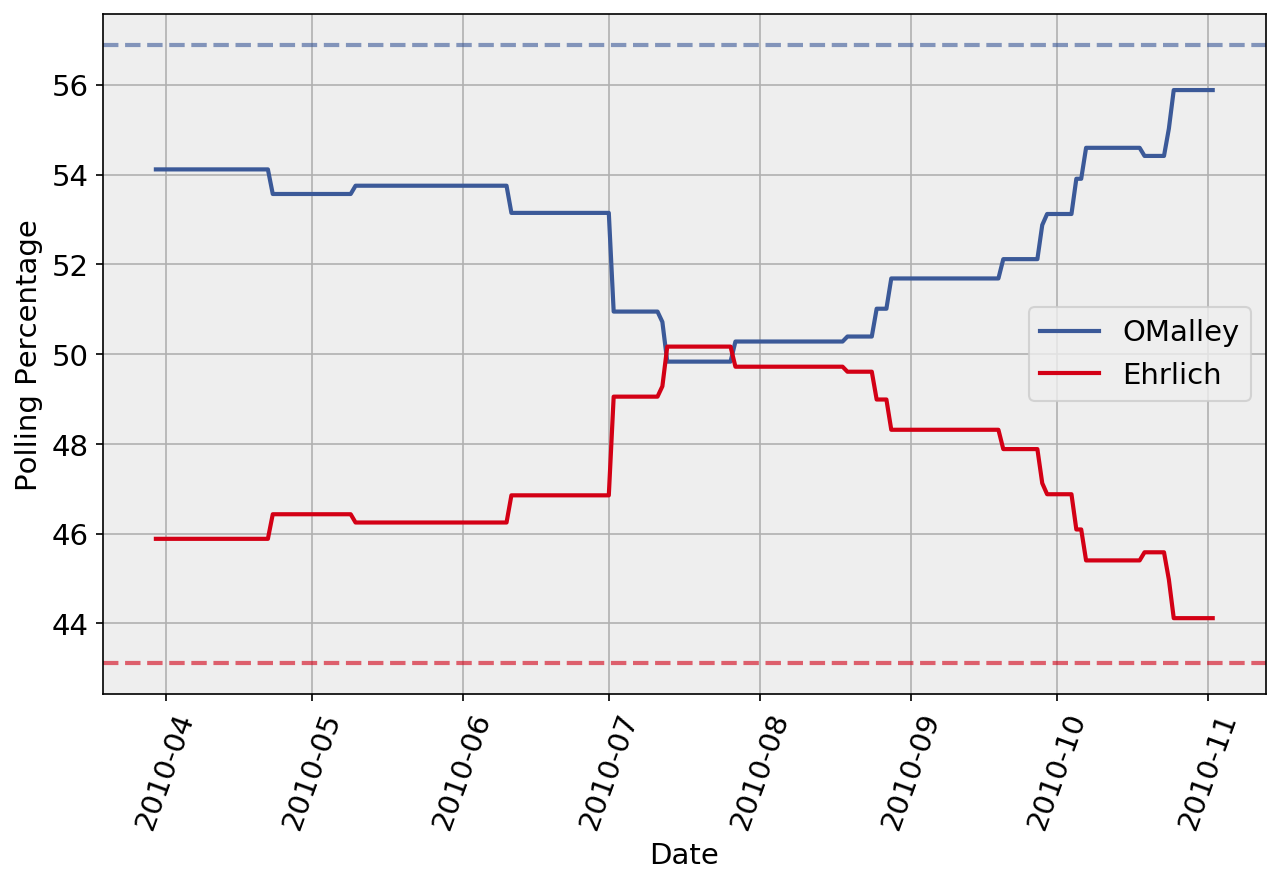

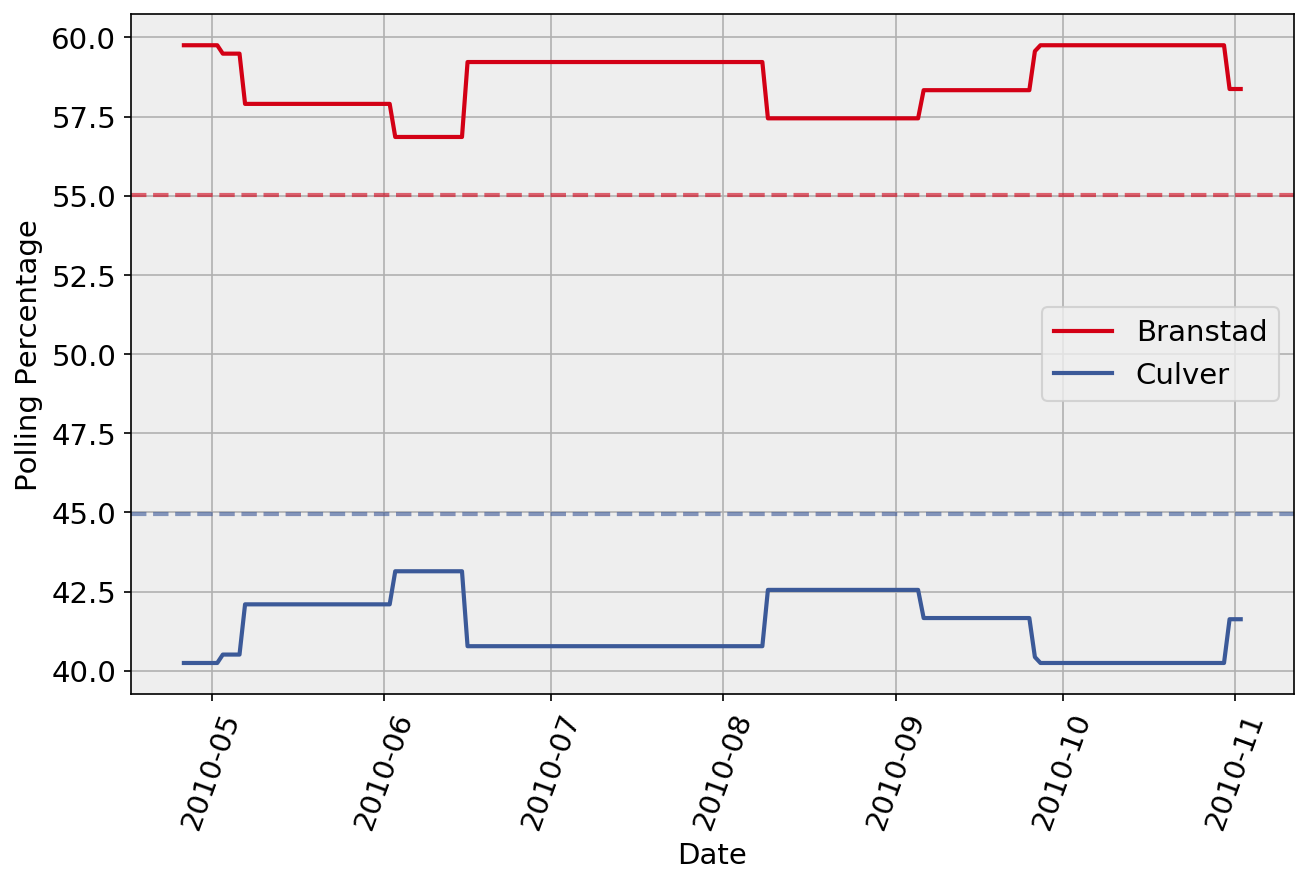

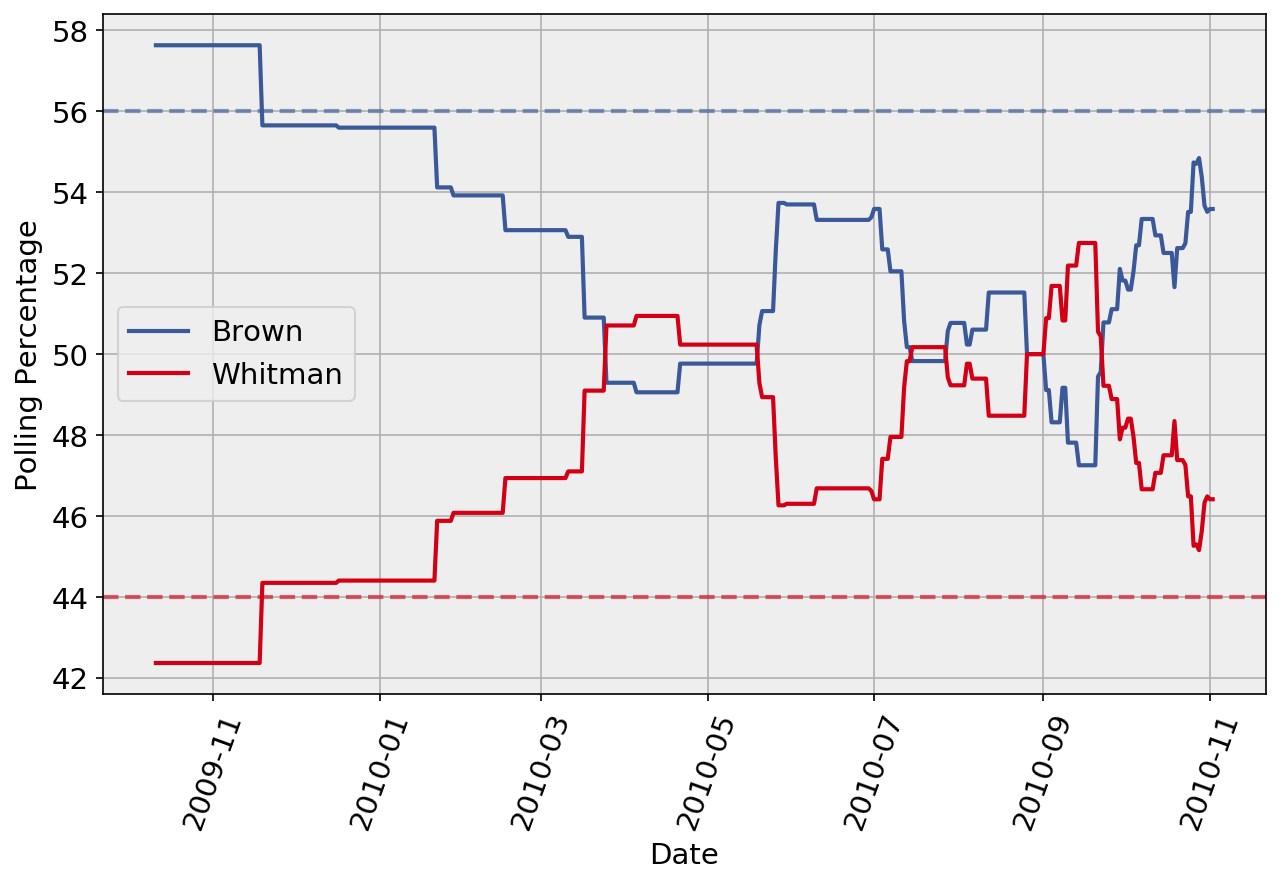

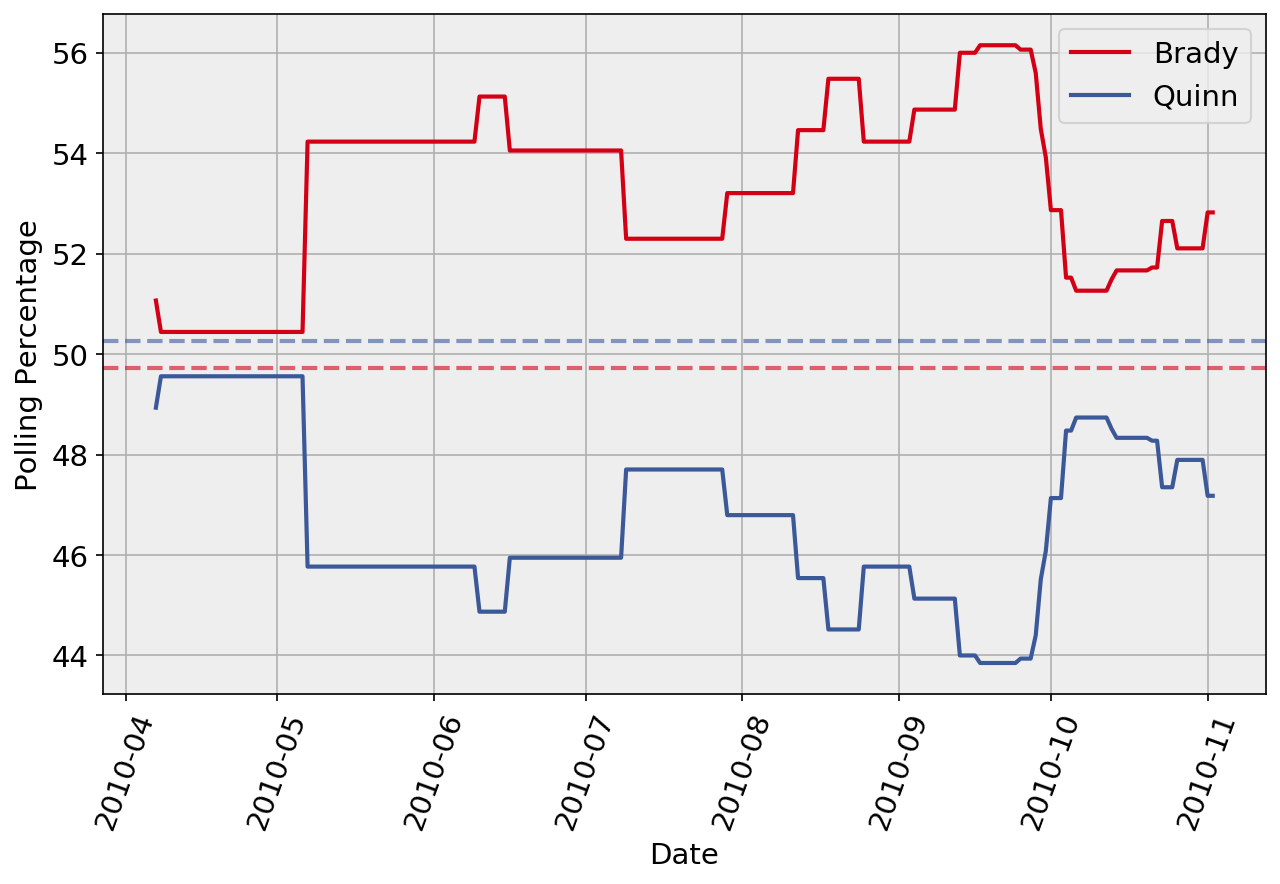

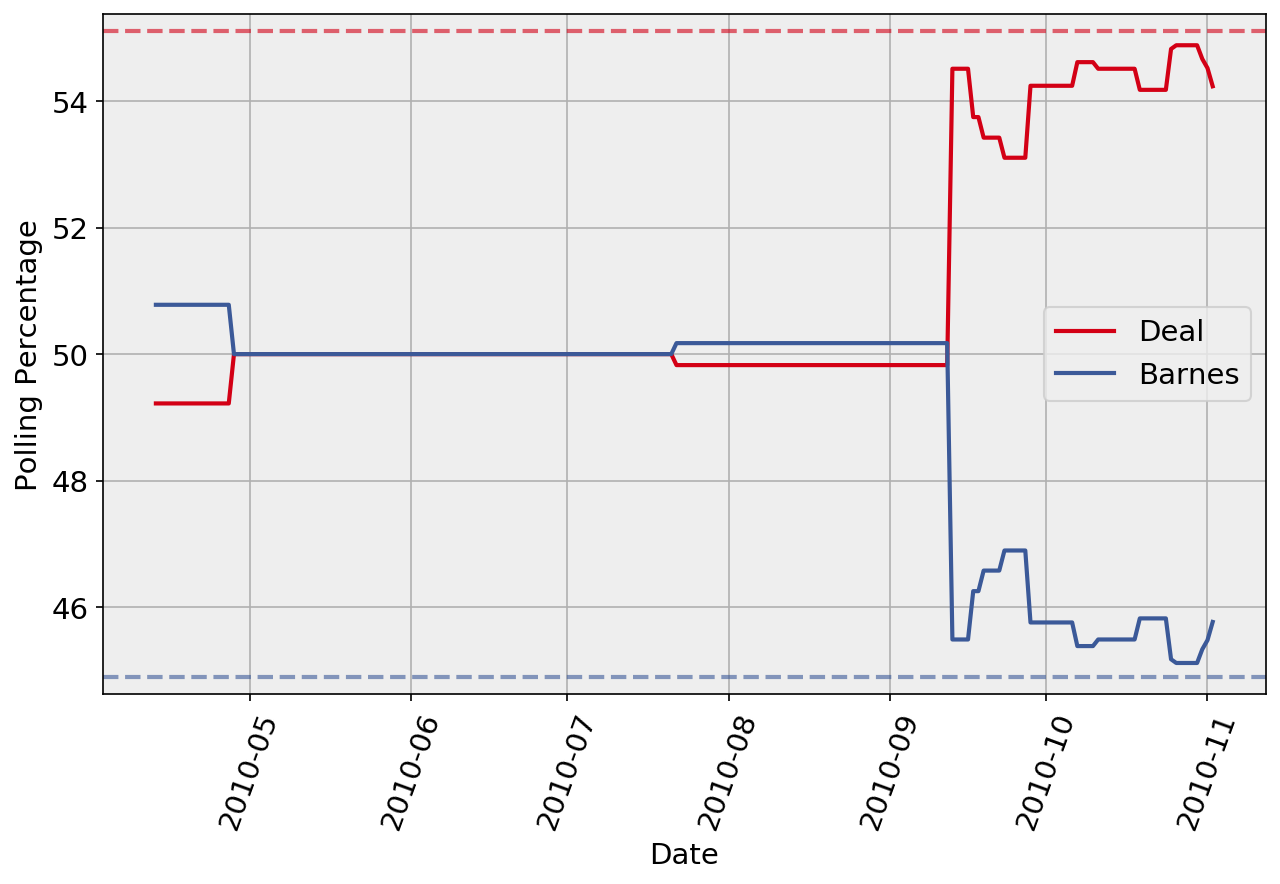

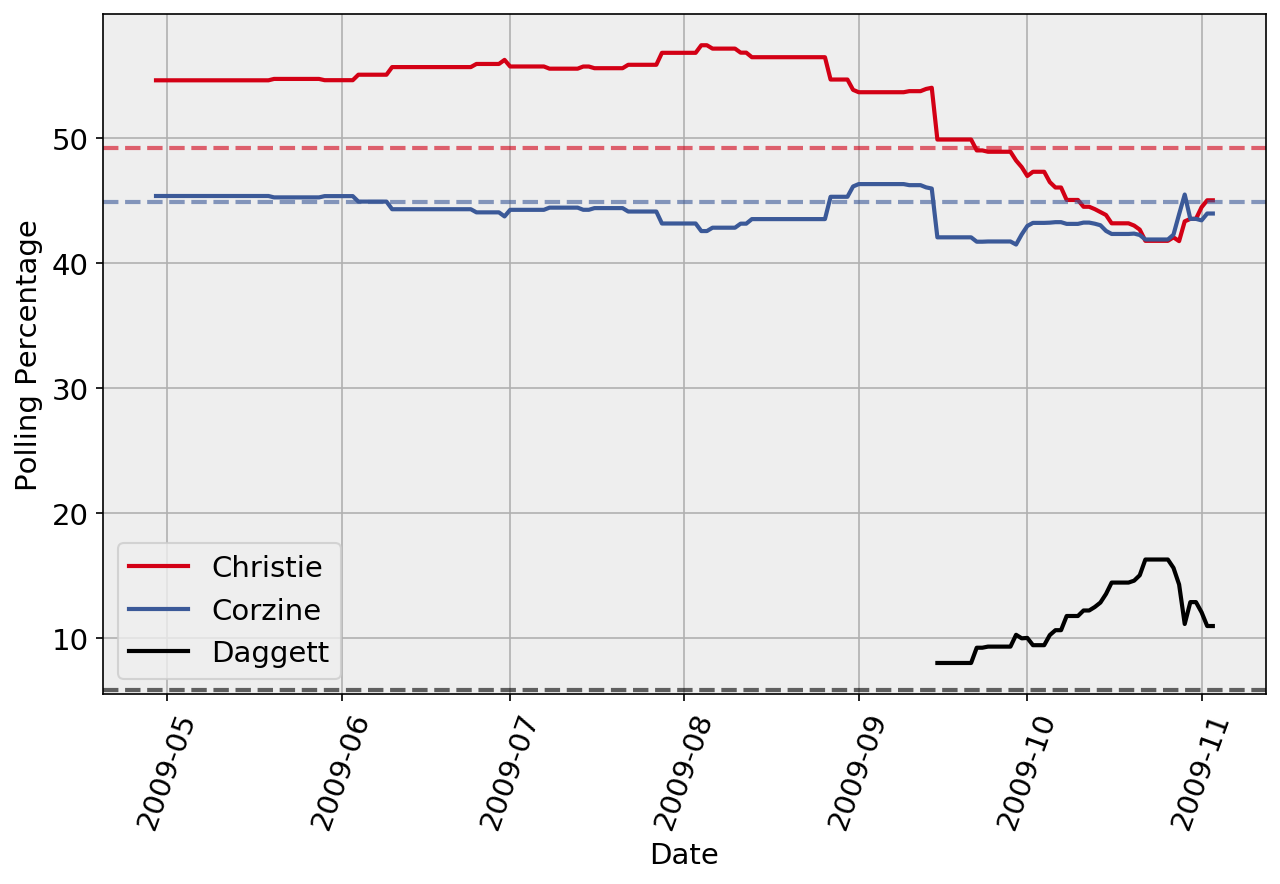

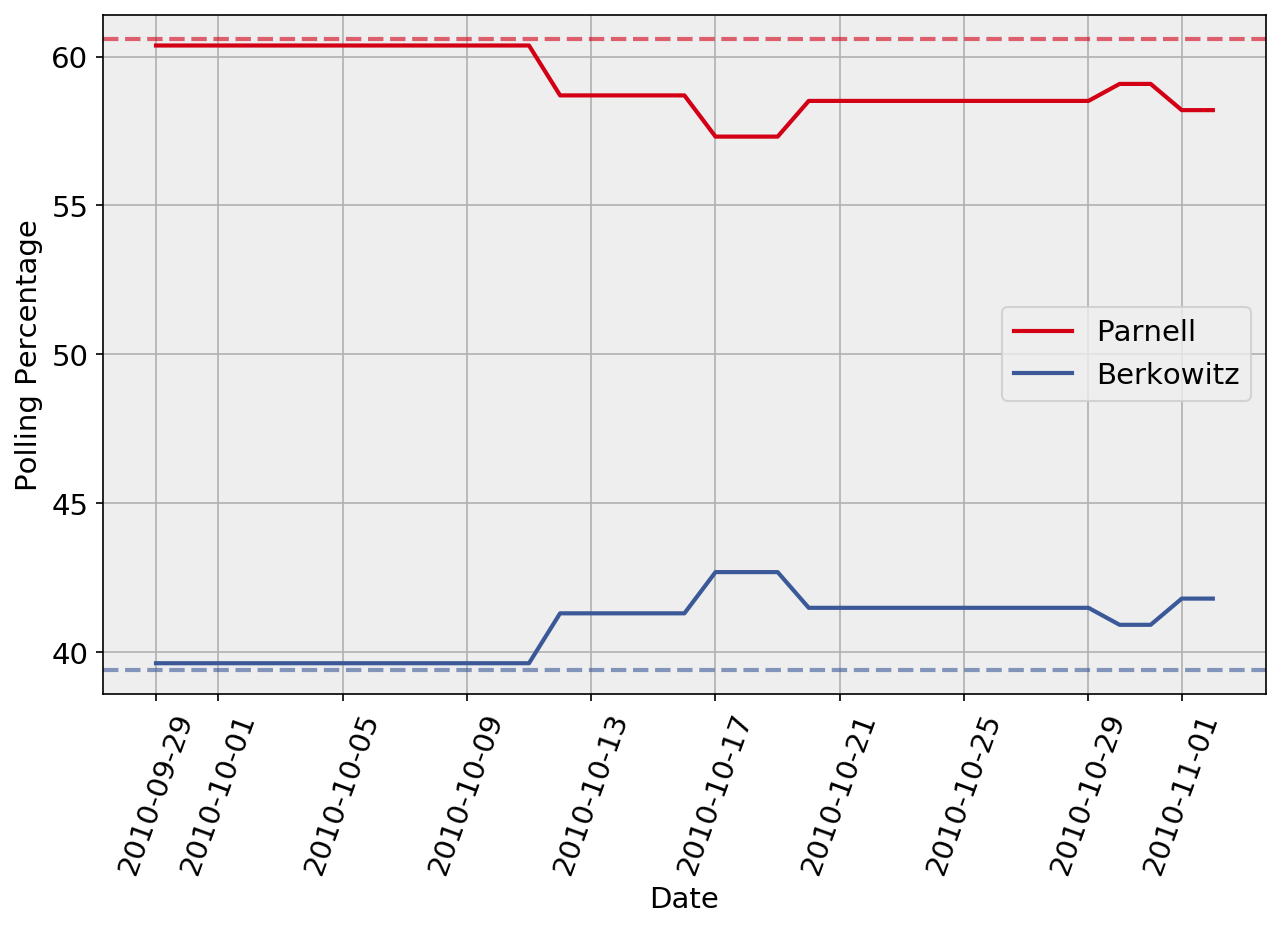

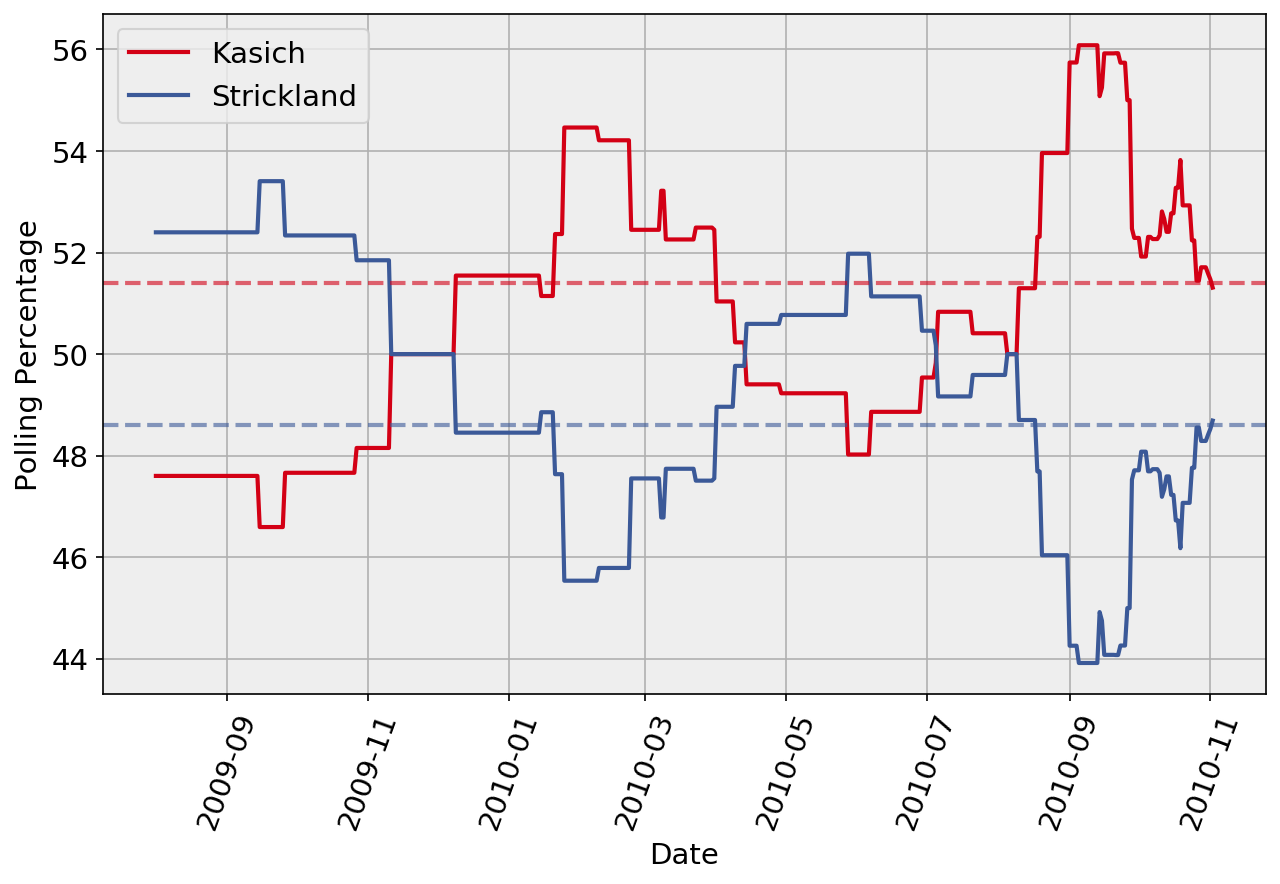

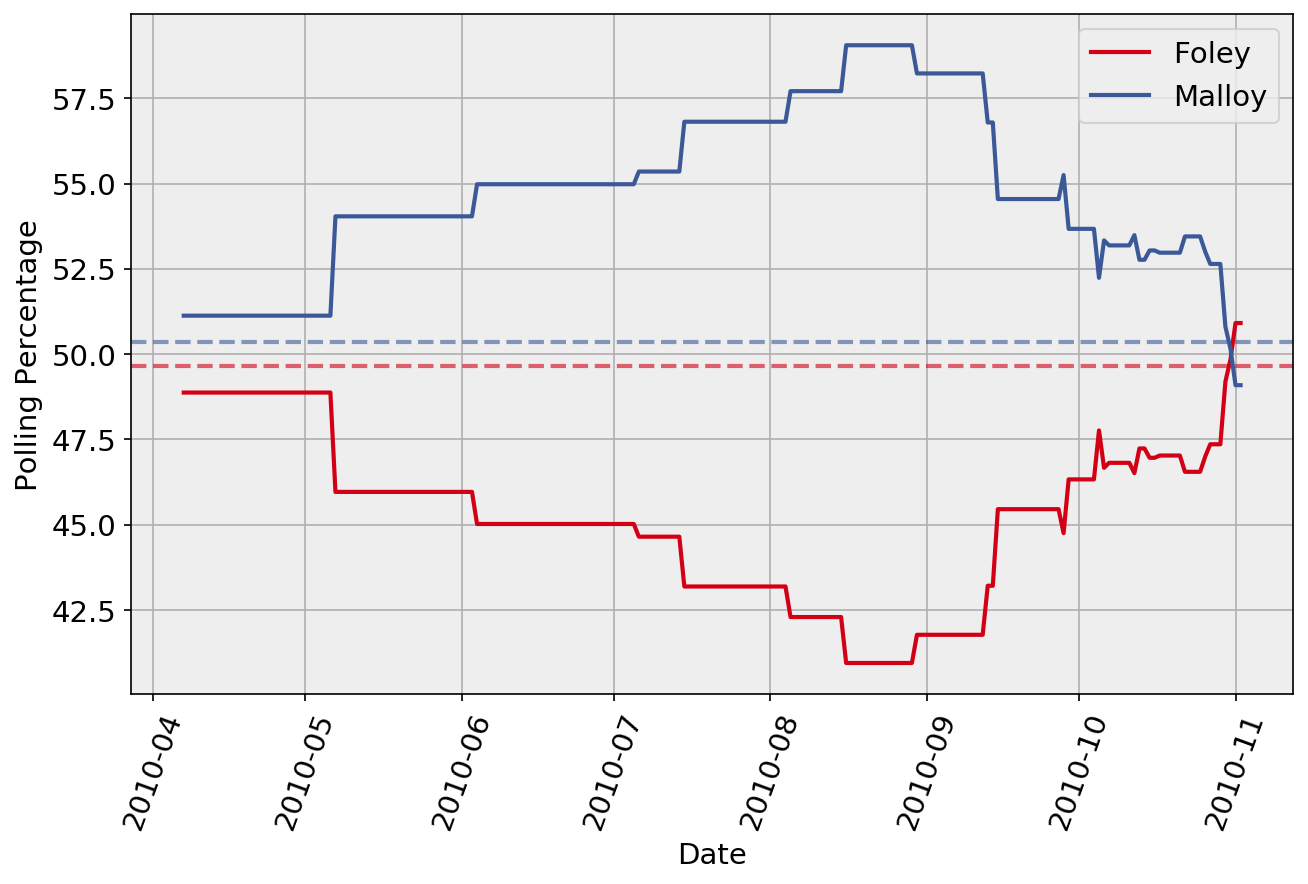

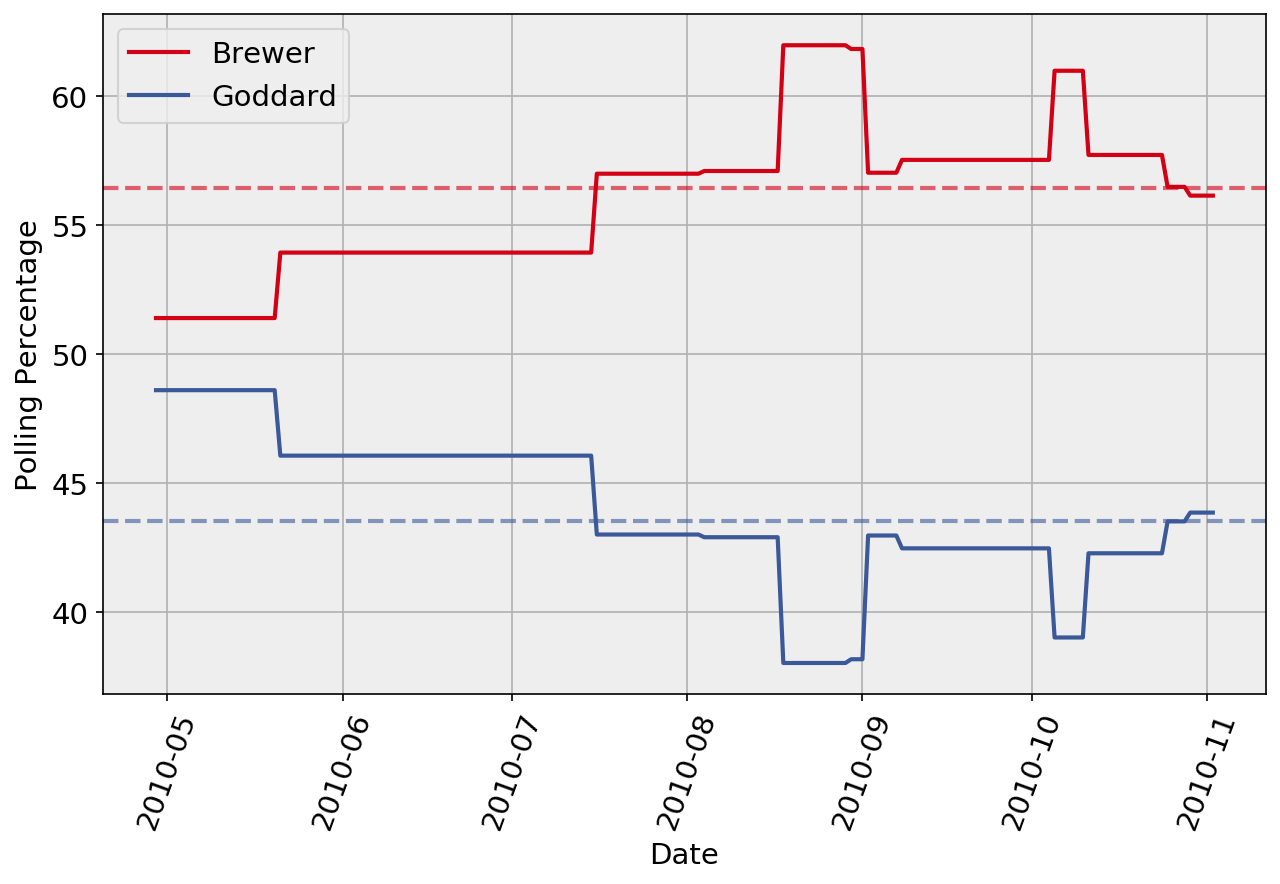

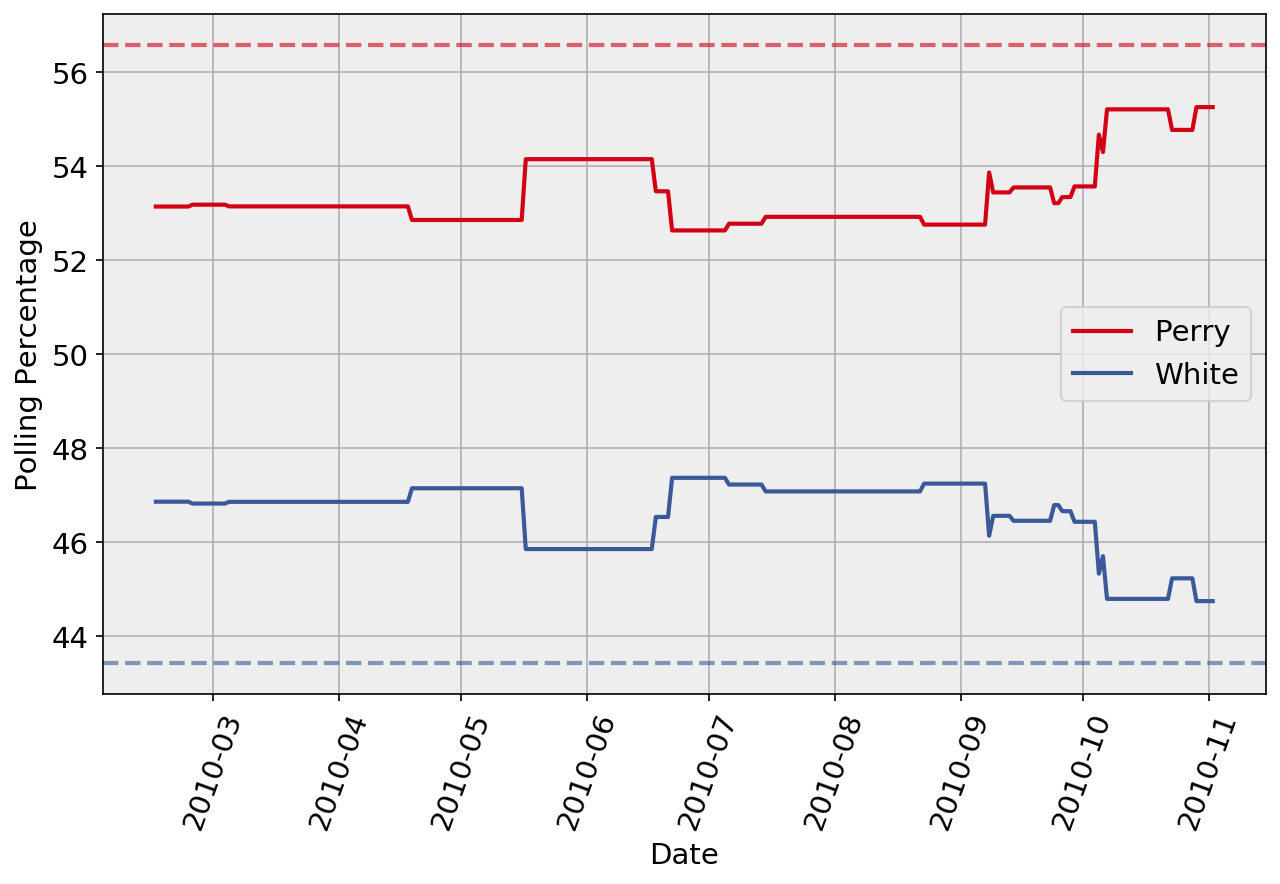

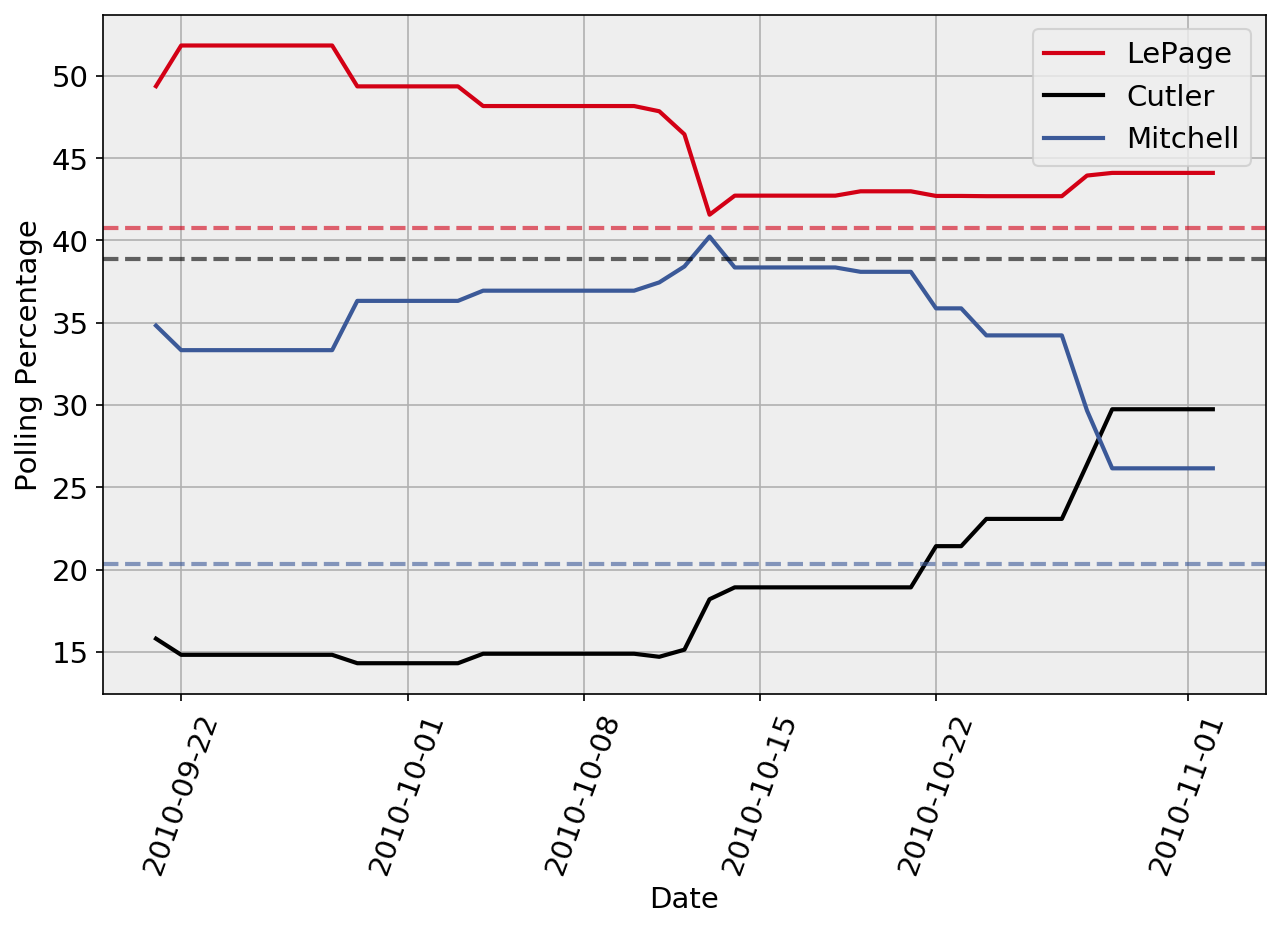

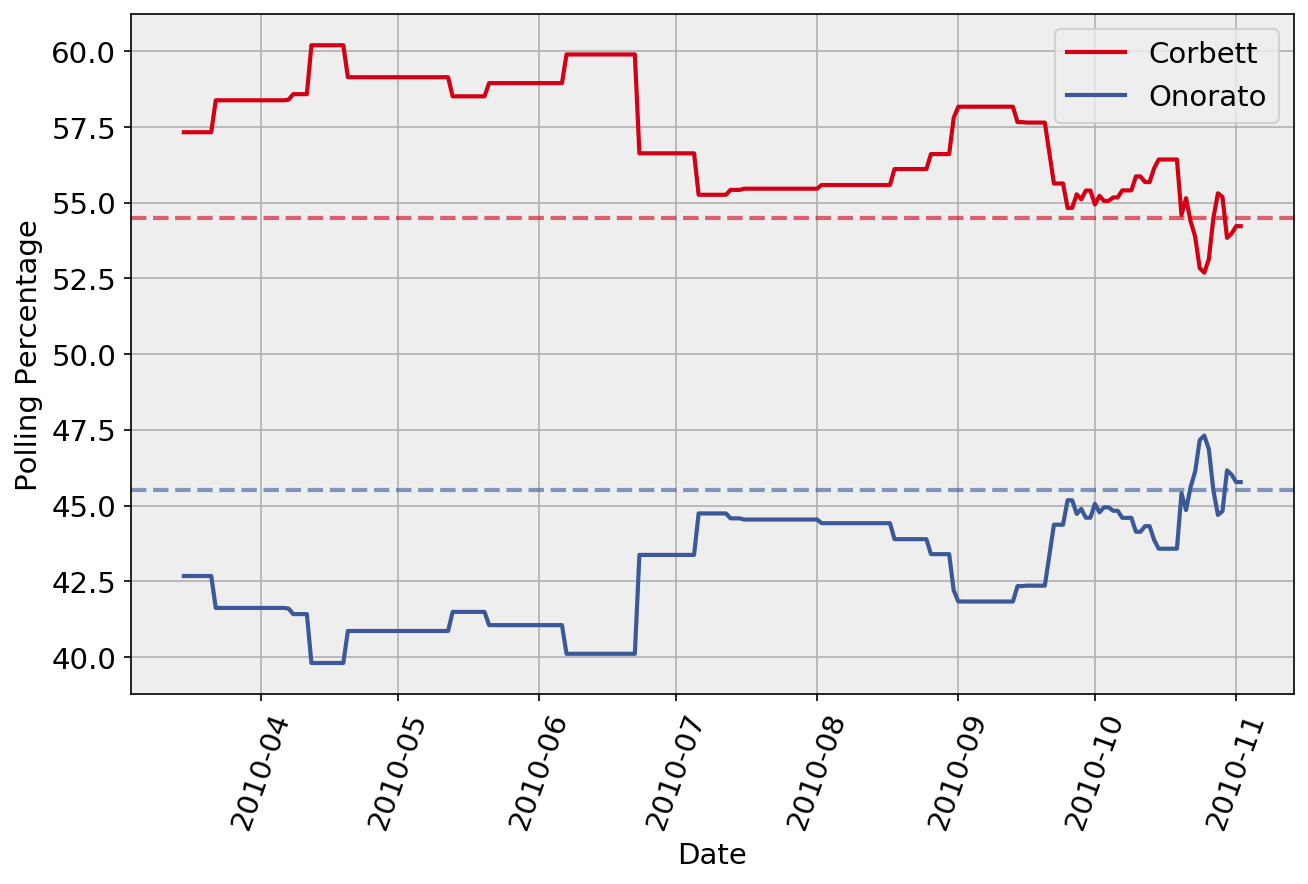

In [168]:
page = requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text.encode('ascii', 'ignore')

for race in find_governor_races(page):
    plot_race(race)
    plt.show()

*Based on visual inspection, these polls generally seem to be within about 5% of the election outcome. The accuracy is higher shortly before the election (usually within 2% or so). In about 20% of cases, the eventual winner trails at some point during the last month of polling -- examples include the Brady/Quinn Illinois race, the Foley/Malloy Connecticut race, the Scott/Sink Florida Race, the Kitzhaber/Dudley Oregon Race, the Corzine/Christie New Jersey race, and the Caprio/Robitaille/Chafee Rhode Island Race.*